 # **Paris sportif - Beat the Bookmakers**

  L’objectif de ce projet est de battre les algorithmes des bookmakers "Pinnacle Sports" et "Bet 365" sur l’estimation de la probabilité d’un joueur de tennis professionnel gagnant un match. 

  Les bases de données disponibles sont 'atp_data.csv' et 'confidence_data.csv'. 
  Nous utilisons princiaplement le fichier 'atp_data.csv' car la base de données est composée de l'ensemble des informations sur le déroulement d'un match entre deux joueurs de 2000 - 2018. 

  ## **Etape 1: Exploration des données**

  ## 1.   Audit des données
  1.   Variables numériques
  2.   Variables qualitatives
  3.   Liaisons entre les variables

## 2.Visualisation des données 

  ## **Etape 2: Modélisation**
  1.   Préparation et modélisation des données
  2.   Classification
  3.   Evaluation du modèle de classification



# **Etape 3: Web Scraping**
  ## Web Scraping (code sur notebook)
  1. Installation de Selenium
  2. Importation des librairies
  3. Extraction et création d'un dataframe comportant tous les joueurs dont on aura les infos pour l'année 2016
  4. Extraction des statistiques de tous les joueurs de l'année 2016 
  5. Fusion des dataframes créés 

## Modélisation avec statistiques scrapées
1. Modelisation sur 2016/2017 sans stats joueurs pour comparer l'ajout de ses stats à notre modélisation
2. Modelisation avec stats joueur sans moyenne mobile
3. Modelisation avec moyenne mobile




### **Définition des variables de la base de donnée 'atp_data.csv':**

* ATP: numéro du tournoi ATP
* Location: Lieu du Tournois
*Tournament: Nom du tournoi ( y compris le sponsors)
*Date: Date du match (remarque : avant 2003, la date indiquée pour tous les matchs joués dans un même tournoi est la date de début)
*Series: Nom de la série de tennis ATP (Grand Chelem, Masters, International ou International Gold)
*Court: Type de terrain (extérieur ou intérieur)
*Surface: Type de surface (argile, dur, moquette ou herbe)
*Round: Tour de match
*Best of: Nombre maximum de sets jouables en match
*Winner: Vainqueur du match 
*Loser: Perdant du match
*Wrank: Classement ATP du vainqueur du match au début du tournoi
*Lrank: Classement ATP du perdant du match au début du tournoi
*Wsets: Nombre de sets gagnés par vainqueur du match
*Lsets: Nombre de sets gagnés par le perdant du match
*Comment: Commentaire sur le match (Terminé, gagné grâce à l'abandon du perdant ou via Walkover)
*PSW: Pinnacles Sports cotes du vainqueur du match
*PSL: Pinnacles Sports cotes de perdant du match
*B365W :Bet365 cotes de gagnant du match
*B365L : Bet365 cotes de perdant du match


## **Etape 0: Chargement des données & des packages PYTHON**

In [ ]:
#1- Vérifier que le GPU est activé
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please change your hardware accelerator")

Default GPU Device:/device:GPU:0


In [ ]:
!ls

sample_data


pour importer le fichier contenant le dataset, nous avons 2 options au moment de l'appel du fichier:

_ option 1: le fichier est sauvegardé sur l'ordinateur, dans ce cas la selection du fichier peut se faire directement à la prochaine étape:


In [ ]:
#option 1: chargement du dataset depuis le PC
! pip install -q kaggle
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

_option 2: utilisation du dataset depuis kaggle

In [ ]:
#selection du fichier 'kaggle.json' correspondant à la clé de l'utilisateur
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luciedu1","key":"083cb83d44d6cf654d832f894ab378ea"}'}

In [ ]:
# Créer un dossier kaggle
! mkdir ~/.kaggle
# Copie le fichier kaggle.json dans le dossier kaggle
! cp kaggle.json ~/.kaggle/
# Change les permisions du fichier kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d edouardthomas/atp-matches-dataset

  0% 0.00/2.37M [00:00<?, ?B/s]
100% 2.37M/2.37M [00:00<00:00, 157MB/s]


In [ ]:
! unzip atp-matches-dataset.zip

Archive:  atp-matches-dataset.zip
  inflating: atp_data.csv            
  inflating: confidence_data.csv     


In [ ]:
#Traitement des données
import pandas as pd
import numpy as np 
from datetime import datetime
#Visualisations
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

#Statistiques
from scipy.stats import pearsonr,chi2_contingency
import statsmodels.api

#ML
from sklearn import linear_model, preprocessing 
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import neighbors, datasets
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve, auc, classification_report

#Text Mining
import re

## **Etape 1: Exploration des données**

## 1.   Audit des données

In [ ]:
df_atp = pd.read_csv('atp_data.csv')
df_atp.head(5)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [ ]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         32743 non-null  float64
 17  PSL         32743 non-null  float64
 18  B365W       39037 non-null  float64
 19  B365L       39057 non-nul

>> La base de donnée ATP est composé de 44 708 lignes de données puis il existe 22 variables dont 13 variables numériques et 9 variables catégorielles. 

>> On remarque que les variables 'Wsets', 'Lsets', 'PSW', 'PSL', 'B365W', 'B365L' ont des valeurs manquantes.
>> Les actions pour les valeurs manquantes: 
* Les variables 'Wsets' et 'Lsets' seront supprimées de la base d'étude  car nous ne sommes pas censés connaître le score des joueurs gagnant et perdant
* Les estimations des joueurs gagnants des bookmakers seront stockés dans une base de données à part pour comparer les estimations de notre modèle

Donc sur notre base de travail, nous avons décidé de ne pas traiter nos valeurs manquantes à cette étape du projet.




In [ ]:
df_atp.isna().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

## 1.   Audit des données: 
1.   Variables numériques

>> Observons les indicateurs de position c'est à dire la moyenne, la médiane, les quantiles, le min & max pour obtenir une compréhension des données quantitatives.

In [ ]:
#creation d'un dataframe ne contenant que les vriable de type numérique
num_df_atp = df_atp.select_dtypes(include=['float64', 'int64'])

In [ ]:
#Calcul de la moyenne
num_stats = pd.DataFrame(num_df_atp.mean(),columns=['num_moyenne'])
num_stats

,num_moyenne
ATP,32.803659
Best of,3.372596
WRank,59.159681
LRank,93.674108
Wsets,2.140630
Lsets,0.406325
PSW,1.927563
PSL,4.240179
B365W,1.822246
B365L,3.551007


In [ ]:
#Calcul de la médiane
num_stats['num_median'] = num_df_atp.median()
num_stats

,num_moyenne,num_median
ATP,32.803659,32.000000
Best of,3.372596,3.000000
WRank,59.159681,41.000000
LRank,93.674108,65.000000
Wsets,2.140630,2.000000
Lsets,0.406325,0.000000
PSW,1.927563,1.549000
PSL,4.240179,2.660000
B365W,1.822246,1.500000
B365L,3.551007,2.500000


In [ ]:
num_stats['diff_moy_med'] = abs(num_stats['num_moyenne'] - num_stats['num_median']) 
num_stats = num_stats.sort_values(by= 'diff_moy_med'  , ascending = False)

In [ ]:
num_stats['Var_num'] = num_stats.index
col_0 = num_stats.pop('Var_num')
num_stats.insert(0, 'Var_num', col_0)

num_stats


,Var_num,num_moyenne,num_median,diff_moy_med
elo_winner,elo_winner,1684.023280,1652.866073,31.157207
LRank,LRank,93.674108,65.000000,28.674108
elo_loser,elo_loser,1608.755552,1580.743828,28.011724
WRank,WRank,59.159681,41.000000,18.159681
PSL,PSL,4.240179,2.660000,1.580179
B365L,B365L,3.551007,2.500000,1.051007
ATP,ATP,32.803659,32.000000,0.803659
Lsets,Lsets,0.406325,0.000000,0.406325
PSW,PSW,1.927563,1.549000,0.378563
Best of,Best of,3.372596,3.000000,0.372596


In [ ]:
filename='output_1.csv'
num_stats.to_csv(filename, index=False)
download = files.download(filename)
print (filename, 'sauvegarde')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

output_1.csv sauvegarde


>> Le calcul de la différence entre la moyenne et la médiane permet de constater l'hétérogénéité des variables.

>> Globalement, nous ne constatons pas de valeurs extrêmes car l'écart entre la moyenne et la médiane ne semble pas être éloigné. L'écart est < 1 (ou proche de 1) pour toutes les autres variables sauf pour les variables suivantes: 
* elo_winner
* LRank
* elo_loser
* WRank

>>Pour ces variables, nous pouvons approfondir une analyse des données avec les quantiles

In [ ]:
var_num = num_stats[num_stats['diff_moy_med'] >18]
var_num

,num_moyenne,num_median,diff_moy_med
WRank,59.159681,41.000000,18.159681
LRank,93.674108,65.000000,28.674108
elo_winner,1684.023280,1652.866073,31.157207
elo_loser,1608.755552,1580.743828,28.011724


In [ ]:
var_num[['q1','q2','q3']] = num_df_atp.quantile(q=[0.25,0.5,0.75]).transpose()
var_num

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,num_moyenne,num_median,diff_moy_med,q1,q2,q3
WRank,59.159681,41.000000,18.159681,17.000000,41.000000,77.000000
LRank,93.674108,65.000000,28.674108,35.000000,65.000000,105.000000
elo_winner,1684.023280,1652.866073,31.157207,1548.476977,1652.866073,1780.755524
elo_loser,1608.755552,1580.743828,28.011724,1501.546103,1580.743828,1684.607134


>> A l'aide des quantiles, on constate que les écarts ne sont pas très important. Donc la base de données est globalement homogène.

In [ ]:
num_stats[['q1','q2','q3']] = num_df_atp.quantile(q=[0.25,0.5,0.75]).transpose()
num_stats.sort_values(by= 'diff_moy_med'  , ascending = False)

,num_moyenne,num_median,diff_moy_med,q1,q2,q3
elo_winner,1684.023280,1652.866073,31.157207,1548.476977,1652.866073,1780.755524
LRank,93.674108,65.000000,28.674108,35.000000,65.000000,105.000000
elo_loser,1608.755552,1580.743828,28.011724,1501.546103,1580.743828,1684.607134
WRank,59.159681,41.000000,18.159681,17.000000,41.000000,77.000000
PSL,4.240179,2.660000,1.580179,1.794000,2.660000,4.270000
B365L,3.551007,2.500000,1.051007,1.720000,2.500000,4.000000
ATP,32.803659,32.000000,0.803659,19.000000,32.000000,49.000000
Lsets,0.406325,0.000000,0.406325,0.000000,0.000000,1.000000
PSW,1.927563,1.549000,0.378563,1.270000,1.549000,2.140000
Best of,3.372596,3.000000,0.372596,3.000000,3.000000,3.000000


>> Pour l'ensemble des variables, l'analyse des quantiles confirment que les données sont assez homogènes dans la base de donnée ATP. 

In [ ]:
num_stats['num_min'] = num_df_atp.min()
num_stats['num_max'] = num_df_atp.max()
num_stats['diff_min_max'] = num_stats['num_min'] - num_stats['num_max']
num_stats.sort_values(by= 'diff_min_max'  , ascending = True)

,num_moyenne,num_median,diff_moy_med,q1,q2,q3,num_min,num_max,diff_min_max
WRank,59.159681,41.000000,18.159681,17.000000,41.000000,77.000000,0.000000,2000.000000,-2000.000000
LRank,93.674108,65.000000,28.674108,35.000000,65.000000,105.000000,0.000000,2000.000000,-2000.000000
elo_winner,1684.023280,1652.866073,31.157207,1548.476977,1652.866073,1780.755524,1318.945207,2392.408923,-1073.463716
elo_loser,1608.755552,1580.743828,28.011724,1501.546103,1580.743828,1684.607134,1327.551888,2392.595567,-1065.043679
PSL,4.240179,2.660000,1.580179,1.794000,2.660000,4.270000,1.010000,121.000000,-119.990000
B365L,3.551007,2.500000,1.051007,1.720000,2.500000,4.000000,1.002000,101.000000,-99.998000
ATP,32.803659,32.000000,0.803659,19.000000,32.000000,49.000000,1.000000,69.000000,-68.000000
PSW,1.927563,1.549000,0.378563,1.270000,1.549000,2.140000,1.000000,46.000000,-45.000000
B365W,1.822246,1.500000,0.322246,1.220000,1.500000,2.000000,1.000000,29.000000,-28.000000
Wsets,2.140630,2.000000,0.140630,2.000000,2.000000,2.000000,0.000000,3.000000,-3.000000


>> Le min & max donne un aperçu de l'étendue de la répartition des valeurs. 
* On retrouve les variables elo_winner, elo_loser, WRank, LRank ayant de grosse difference entre la valeur min et max.
* En plus d'autres varaibles: PSL, B365L, ATP, PSW, B365W 

In [ ]:
stats_desc = num_df_atp.describe().transpose()
stats_desc

,count,mean,std,min,25%,50%,75%,max
ATP,44708.0,32.803659,18.170565,1.000000,19.000000,32.000000,49.000000,69.000000
Best of,44708.0,3.372596,0.778702,3.000000,3.000000,3.000000,3.000000,5.000000
WRank,44708.0,59.159681,74.881003,0.000000,17.000000,41.000000,77.000000,2000.000000
LRank,44708.0,93.674108,124.987643,0.000000,35.000000,65.000000,105.000000,2000.000000
Wsets,44521.0,2.140630,0.462388,0.000000,2.000000,2.000000,2.000000,3.000000
Lsets,44521.0,0.406325,0.557349,0.000000,0.000000,0.000000,1.000000,2.000000
PSW,32743.0,1.927563,1.359136,1.000000,1.270000,1.549000,2.140000,46.000000
PSL,32743.0,4.240179,5.744329,1.010000,1.794000,2.660000,4.270000,121.000000
B365W,39037.0,1.822246,1.107547,1.000000,1.220000,1.500000,2.000000,29.000000
B365L,39057.0,3.551007,3.498689,1.002000,1.720000,2.500000,4.000000,101.000000


In [ ]:
stats_std = stats_desc.iloc[:,1:3]
stats_std['I1'] = stats_std['mean'] - stats_std['std']  
stats_std['I2'] = stats_std['mean'] +stats_std['std']
stats_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,mean,std,I1,I2
ATP,32.803659,18.170565,14.633094,50.974224
Best of,3.372596,0.778702,2.593893,4.151298
WRank,59.159681,74.881003,-15.721322,134.040683
LRank,93.674108,124.987643,-31.313536,218.661751
Wsets,2.140630,0.462388,1.678242,2.603019
Lsets,0.406325,0.557349,-0.151023,0.963674
PSW,1.927563,1.359136,0.568427,3.286700
PSL,4.240179,5.744329,-1.504150,9.984508
B365W,1.822246,1.107547,0.714698,2.929793
B365L,3.551007,3.498689,0.052319,7.049696


>> Deux autres indicateurs de la dispersion des données sont la variance et l'écart type:
  * La variance mesure la dispersion autour de la moyenne c'est à dire que les valeurs d'une liste numérique sont écartées de la moyenne.
  * L'écart type est la racine carré de la variance.

>> On constate que les valeurs numériques ne sont pas très éloignées de la moyenne. Peut être moins pour WRank, LRank. 

>> Les variables WRank, LRank seront renommées en 'Rank' dans la base d'étude à l'étape de modélisation. 

## 1.   Audit des données: 
2.   Variables catégorielles
>>Quelles sont les modalités de chaque variable et comment se répartissent-elles?

In [ ]:
cat_df_atp = df_atp.select_dtypes(include='object')
cat_df_atp

,Location,Tournament,Date,Series,Court,Surface,Round,Winner,Loser,Comment
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,Dosedel S.,Ljubicic I.,Completed
1,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,Kiefer N.,Tarango J.,Completed
2,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,Gaudio G.,Luxa P.,Completed
3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,El Aynaoui Y.,Dupuis A.,Completed
4,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,Cherkasov A.,Arazi H.,Completed
...,...,...,...,...,...,...,...,...,...,...
44703,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,Bautista Agut R.,Pouille L.,Completed
44704,Acapulco,Abierto Mexicano,2018-03-03,ATP500,Outdoor,Hard,Semifinals,Anderson K.,Donaldson J.,Completed
44705,Sao Paulo,Brasil Open,2018-03-03,ATP250,Indoor,Clay,Semifinals,Jarry N.,Zeballos H.,Completed
44706,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,Del Potro J.M.,Anderson K.,Completed


In [ ]:
cat_df_atp.describe().transpose()

,count,unique,top,freq
Location,44708,115,Paris,2784
Tournament,44708,207,Australian Open,2159
Date,44708,4104,2000-01-17,127
Series,44708,8,International,10792
Court,44708,2,Outdoor,36532
Surface,44708,4,Hard,23799
Round,44708,8,1st Round,20728
Winner,44708,899,Federer R.,970
Loser,44708,1400,Lopez F.,369
Comment,44708,4,Completed,43015


>> La base de données ATP est composée de 10 variables catégorielles. Dans le tableau ci-dessus, nous observons les top des modalités pour chacune des variables ainsi que la fréquence de la modalité. 

In [ ]:
cat_df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Location    44708 non-null  object
 1   Tournament  44708 non-null  object
 2   Date        44708 non-null  object
 3   Series      44708 non-null  object
 4   Court       44708 non-null  object
 5   Surface     44708 non-null  object
 6   Round       44708 non-null  object
 7   Winner      44708 non-null  object
 8   Loser       44708 non-null  object
 9   Comment     44708 non-null  object
dtypes: object(10)
memory usage: 3.4+ MB


In [ ]:
#Fréquence des modalités des variables catégorielles
def DataFrameInfo(df):
  my_list=[]
  pos=0
  for pos in range(0,9):
    col=df.columns[pos]
    valeur= df[col].value_counts(ascending=False).head(20)
    modalite= len(df[col].value_counts())
    nul= df[col].isna().sum()
    if col not in my_list:
      my_list.append
      print("colonne=",pos,df.columns[pos])
      print("=================================")
      print(valeur,"\n","nombre de modalités:",modalite,"\n", "nombre de valeur nulle:",nul)
      print("=================================")
    else:
      pos=pos+1

  
DataFrameInfo(cat_df_atp)

In [ ]:
cat_df_atp.groupby(['Series','Location','Tournament']).agg({'Tournament':'count'})

Tournament
Series       Location         Tournament                
ATP250       's-Hertogenbosch Ordina Open             31
                              Ricoh Open              27
                              Topshelf Open           85
                              Unicef Open             89
             Antalya          Antalya Open            27
...                                                  ...
Masters 1000 Toronto          Rogers Masters         157
Masters Cup  Houston          Masters Cup             30
             Lisbon           Masters Cup             15
             London           Masters Cup            120
             Shanghai         Masters Cup             75

[278 rows x 1 columns]

>> On comprend que la variable 'Series' représente des classes de tournois qui sont joués dans plusieurs lieux différents('location'). Pour chaque lieu , nous dénombrons plusieurs tournois ('Tournament'). 

In [ ]:
cat_df_atp.groupby(['Comment','Round']).agg({'Round':'count'})

Round
Comment      Round               
Completed    1st Round      19920
             2nd Round      11860
             3rd Round       3007
             4th Round        720
             Quarterfinals   4070
             Round Robin      308
             Semifinals      2077
             The Final       1053
Disqualified The Final          1
Retired      1st Round        804
             2nd Round        369
             3rd Round         85
             4th Round         26
             Quarterfinals    115
             Round Robin        4
             Semifinals        55
             The Final         18
Walkover     1st Round          4
             2nd Round         91
             3rd Round         36
             4th Round          6
             Quarterfinals     55
             Semifinals        20
             The Final          4

>> Dans ce croisement entre la variable 'comment' & 'Round, on remarque que une finale a eu un commentaire 'disqualified'.

In [ ]:
cat_df_atp.groupby(['Court','Surface']).agg({'Surface':'count'})

Surface
Court   Surface         
Indoor  Carpet      1523
        Clay         162
        Hard        6491
Outdoor Clay       14308
        Grass       4916
        Hard       17308

Dans cette table, qu'il s'agissent de tournois intérieur ('Indoor') ou extérieur ('Outdoor'), la surface la plus représentée est le dur ('hard'). Logiquement, il n'y a pas de tournoi sur herbe ('grass') en intérieur ni de tournoi sur moquette ('carpet') en extérieur.
Les tournois sur terre ('clay') sont plus représnetés en extérieur qu'en intérieur.

  ## 1.   Audit des données:
 3.   Liaisons entre les variables
 

**3.1 Variables quantitatives**

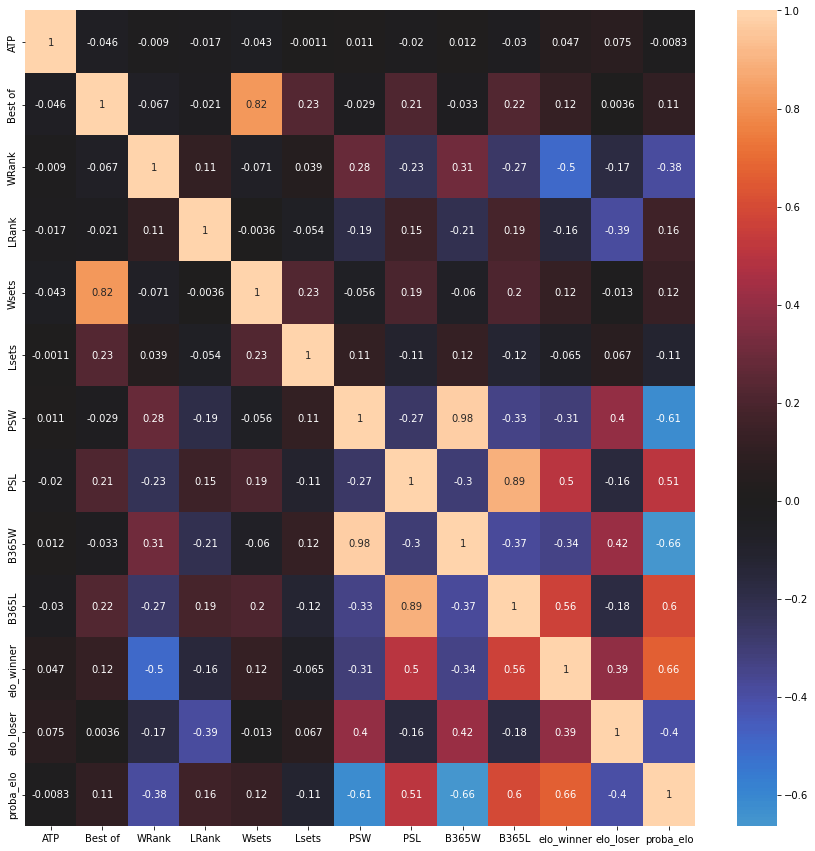

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(df_atp.corr(), annot = True, center = 0);

>> La matrice de confusion montre le lien entre les variables numériques: 
* 'Best of' & 'Wsets' = 0,82
* 'B365W' & 'PSW' = 0,98
* 'B365L' & 'PSL' = 0,89
* 'elo_winner' & 'proba_elo' = 0,66

>> La relation entre le 'Best of' et 'Wsets' est lié au jeu du tennis

>> On constate que les estimations des deux bookmakers des joueurs gagnant et perdant sont similaires

>> Le elo_winner et la proba_elo sont corrélés car la proba_elo dépend du elo_winner


In [ ]:
df_atp['PSW'] = df_atp['PSW'].fillna(0)
df_atp['B365W'] = df_atp['B365W'].fillna(0)
df_atp['PSL'] = df_atp['PSL'].fillna(0)
df_atp['B365L'] = df_atp['B365L'].fillna(0)
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         44708 non-null  float64
 17  PSL         44708 non-null  float64
 18  B365W       44708 non-null  float64
 19  B365L       44708 non-nul

In [ ]:
pd.DataFrame(pearsonr(df_atp['B365W'], df_atp['PSW']), index=['coefficient','p_value'], columns=['Test de Persons'])
#Le coefficient est proche de 1 et la p-value < 5% => Corrélation entre B365W & PSW

,Test de Persons
coefficient,0.804774
p_value,0.000000


In [ ]:
pd.DataFrame(pearsonr(df_atp['B365L'], df_atp['PSL']), index=['coefficient','p_value'], columns=['Test de Persons'])
#Le coefficient est proche de 1 et la p-value < 5% => Corrélation entre B365L & PSL

,Test de Persons
coefficient,0.820491
p_value,0.000000


In [ ]:
pd.DataFrame(pearsonr(df_atp['elo_winner'], df_atp['proba_elo']), index=['coefficient','p_value'], columns=['Test de Persons'])

#p_value < 5% et le coefficient assez proche de 1 =>  Corrélation elo_winner & proba_elo

,Test de Persons
coefficient,0.662299
p_value,0.000000


In [ ]:
pd.DataFrame(pearsonr(df_atp['elo_loser'], df_atp['proba_elo']), index=['coefficient','p_value'], columns=['Test de Persons'])

#p_value < 5% et le coefficient -0,40 ; donc pas proche de 1 =>  on peut dire que c'est corrélé mais pas totalement

,Test de Persons
coefficient,-0.401453
p_value,0.000000


In [ ]:
print('max_proba_elo:',max(df_atp['proba_elo']))
print('min_proba_elo:',min(df_atp['proba_elo']))

df_atp.sort_values(by = 'proba_elo' , ascending = False )
proba_elo_99 = df_atp[df_atp.proba_elo > 0.99]
proba_elo_99
#Proba_elo => elo_winner > elo_loser

max_proba_elo: 0.9956014083019812
min_proba_elo: 0.0088987922569267


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
17239,63,Basel,Davidoff Swiss Indoors,2006-10-24,International,Indoor,Carpet,1st Round,3,Federer R.,...,2.0,0.0,Completed,1.012,61.00,1.010,15.0,2255.528016,1396.842753,0.992917
17556,6,Melbourne,Australian Open,2007-01-15,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,...,3.0,0.0,Completed,1.012,61.00,1.000,17.0,2281.828892,1459.622471,0.991277
17938,17,Dubai,Dubai Tennis Championships,2007-02-26,International Gold,Outdoor,Hard,1st Round,3,Federer R.,...,2.0,1.0,Completed,1.010,71.00,1.000,17.0,2296.466034,1463.803931,0.991782
24160,31,Paris,French Open,2009-05-25,Grand Slam,Outdoor,Clay,1st Round,5,Nadal R.,...,3.0,0.0,Completed,0.000,0.00,1.002,34.0,2224.475628,1412.781778,0.990738
33052,51,New York,US Open,2012-08-28,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,...,3.0,0.0,Completed,1.000,71.00,1.000,41.0,2261.281751,1421.547328,0.992107
35791,51,New York,US Open,2013-08-30,Grand Slam,Outdoor,Hard,2nd Round,5,Nadal R.,...,3.0,0.0,Completed,1.010,51.00,1.000,41.0,2310.028231,1464.217199,0.992377
36232,3,Doha,Qatar Exxon Mobil Open,2015-01-06,ATP250,Outdoor,Hard,1st Round,3,Djokovic N.,...,2.0,0.0,Completed,1.040,14.80,1.030,15.0,2293.597674,1429.295707,0.993141
36799,18,Dubai,Dubai Tennis Championships,2015-02-26,ATP500,Outdoor,Hard,Quarterfinals,3,Djokovic N.,...,2.0,0.0,Completed,1.010,41.00,1.010,26.0,2286.403124,1485.068989,0.990174
38294,52,New York,US Open,2015-08-31,Grand Slam,Outdoor,Hard,1st Round,5,Djokovic N.,...,3.0,0.0,Completed,1.010,51.00,1.000,67.0,2306.995239,1405.384105,0.994459
38560,57,Beijing,China Open,2015-10-08,ATP500,Outdoor,Hard,2nd Round,3,Djokovic N.,...,2.0,0.0,Completed,1.010,51.00,1.002,41.0,2325.227274,1509.675779,0.990939


**3.2 Variables qualitatives**

In [ ]:
#Table de contingence
pd.crosstab(df_atp['Best of'] , df_atp['Comment'])


Comment,Completed,Disqualified,Retired,Walkover
Best of,,,,
3,35060,1,1126,192
5,7955,0,350,24


In [ ]:
pd.crosstab(df_atp['Winner'] , df_atp['Comment'])

Comment,Completed,Disqualified,Retired,Walkover
Winner,,,,
Hajek J.,1,0,0,0
Abel M.,1,0,1,0
Acasuso J.,168,0,5,0
Agassi A.,213,0,8,1
Agenor R.,5,0,1,0
...,...,...,...,...
di Mauro A.,14,0,0,0
di Pasquale A.,21,0,1,0
van Gemerden M.,3,0,1,0


In [ ]:
pd.crosstab(df_atp['Comment'] , df_atp['Wsets'])

Wsets,0.0,1.0,2.0,3.0
Comment,,,,
Completed,2,2,35051,7959
Disqualified,1,0,0,0
Retired,331,954,184,0
Walkover,37,0,0,0


In [ ]:
pd.crosstab(df_atp['Comment'] , df_atp['Lsets'])

Lsets,0.0,1.0,2.0
Comment,,,
Completed,26824,14678,1512
Disqualified,0,1,0
Retired,1115,321,33
Walkover,37,0,0


In [ ]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         44708 non-null  float64
 17  PSL         44708 non-null  float64
 18  B365W       44708 non-null  float64
 19  B365L       44708 non-nul

In [ ]:
#Test du Chi2  = test de proportions / On rejette l'indépendances entre deux variables lorsque la p-values < 5%
table = pd.crosstab(df_atp['Winner'],df_atp['Court'])
table = pd.crosstab(df_atp['Loser'],df_atp['Court'])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_value = resultats_test[1]
degre_liberte = resultats_test[2]

print('statistique du test:',statistique, 
      'p_value:', p_value,
      'degre de liberte:', degre_liberte)

#V-Cramer - Mesure la corrélation entre deux variables qualitatives
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

print('correlation:',V_Cramer(table, df_atp.shape[0]))


statistique du test: 2576.5802521034666 p_value: 1.1720487537706107e-72 degre de liberte: 1399
correlation: 0.16229372282150042


In [ ]:
table = pd.crosstab(df_atp['Winner'],df_atp['Surface'])
table = pd.crosstab(df_atp['Loser'],df_atp['Surface'])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_value = resultats_test[1]
degre_liberte = resultats_test[2]

print('statistique du test:',statistique, 
      'p_value:', p_value,
      'degre de liberte:', degre_liberte)

#V-Cramer - Mesure la corrélation entre deux variables qualitatives
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

print('correlation:',V_Cramer(table, df_atp.shape[0]))


statistique du test: 10689.76499407459 p_value: 0.0 degre de liberte: 4197
correlation: 0.22002550454773706


In [ ]:
table = pd.crosstab(df_atp['Winner'],df_atp['Round'])
table = pd.crosstab(df_atp['Loser'],df_atp['Round'])
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_value = resultats_test[1]
degre_liberte = resultats_test[2]

print('statistique du test:',statistique, 
      'p_value:', p_value,
      'degre de liberte:', degre_liberte)

#V-Cramer - Mesure la corrélation entre deux variables qualitatives
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

print('correlation:',V_Cramer(table, df_atp.shape[0]))


statistique du test: 12840.693179455431 p_value: 4.4462284780565686e-88 degre de liberte: 9793
correlation: 0.09868755178040271


In [ ]:
table = pd.crosstab(df_atp['Winner'],df_atp['Comment'])
table = pd.crosstab(df_atp['Loser'],df_atp['Comment'])

resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_value = resultats_test[1]
degre_liberte = resultats_test[2]

print('statistique du test:',statistique, 
      'p_value:', p_value,
      'degre de liberte:', degre_liberte)

#V-Cramer - Mesure la corrélation entre deux variables qualitatives
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

print('correlation:',V_Cramer(table, df_atp.shape[0]))


statistique du test: 2661.689736917259 p_value: 1.0 degre de liberte: 4197
correlation: 0.0


Analyse des corrélations qualitatives pour les joueurs gagnant:  
* Court: p_value < 5% et corr = 0,23 => Corrélation même si le V_Cramer n'est pas élevé
* Surface: p_values < 5% et corr = 0,29 => idem 
* Round: p-value < 5% et corr = 0,10 => idem 
* Comment: p-value > 5% et corr = 0 => aucune corrélation 

>> Le constat est le même avec les joueurs perdant mais avec des corrélations plus faibles: 
* Court: 0,16 
* Surface : 0,22
* Round: 0,09
* Comment: 0 

"Comment" peut être supprimé car c'est une information que l'on a en fin de match. 

**3.3 Variables quantitatives & qualitatives**

In [ ]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         44708 non-null  float64
 17  PSL         44708 non-null  float64
 18  B365W       44708 non-null  float64
 19  B365L       44708 non-nul

In [ ]:
result = statsmodels.formula.api.ols('PSW ~ Winner' , data = df_atp).fit()
anova = statsmodels.api.stats.anova_lm(result)
anova

,df,sum_sq,mean_sq,F,PR(>F)
Winner,898.0,19647.729828,21.879432,13.059978,0.0
Residual,43809.0,73393.385742,1.675304,NaN,NaN


In [ ]:
result = statsmodels.formula.api.ols('PSL ~ Loser' , data = df_atp).fit()
anova = statsmodels.api.stats.anova_lm(result)
anova

,df,sum_sq,mean_sq,F,PR(>F)
Loser,1399.0,1.449944e+05,103.641467,4.106771,0.0
Residual,43308.0,1.092952e+06,25.236730,NaN,NaN


In [ ]:
result = statsmodels.formula.api.ols('B365W  ~ Winner' , data = df_atp).fit()
anova = statsmodels.api.stats.anova_lm(result)
anova

,df,sum_sq,mean_sq,F,PR(>F)
Winner,898.0,13109.901873,14.599000,12.487556,0.0
Residual,43809.0,51216.394557,1.169084,NaN,NaN


In [ ]:
result = statsmodels.formula.api.ols('elo_winner ~ Winner' , data = df_atp).fit()
anova = statsmodels.api.stats.anova_lm(result)
anova


,df,sum_sq,mean_sq,F,PR(>F)
Winner,898.0,1.065056e+09,1.186031e+06,139.919753,0.0
Residual,43809.0,3.713475e+08,8.476512e+03,NaN,NaN


In [ ]:
result = statsmodels.formula.api.ols('proba_elo  ~ Winner' , data = df_atp).fit()
anova = statsmodels.api.stats.anova_lm(result)
anova

,df,sum_sq,mean_sq,F,PR(>F)
Winner,898.0,609.131095,0.67832,25.694272,0.0
Residual,43809.0,1156.542118,0.02640,NaN,NaN


Globalement les modalités testées ont un effet statistique significatif sur la variable cible.

## 2.Visualisation des données 

Une étape préalable a la dataviz consiste à séparer la colonne date en année/ mois&jour.

In [ ]:
#creation de la fonction split
def split(annee):
# Découpage de la chaîne sur le caractère '-'
  splits=annee.split('-')
# On renvoie le premier élément du découpage 
  annee = splits[0]
  return annee

    
# Application de la fonction
year = df_atp['Date'].apply(split)

# Création de la nouvelle colonne
df_atp['year'] = year

df_atp['year']=df_atp['year'].astype(int)

Affichage du nombre de matches joués en fonction des années

2000    2963
2005    2910
2006    2908
2004    2877
2007    2824
2003    2816
2002    2806
2009    2731
2008    2689
2012    2683
2010    2679
2011    2675
2017    2635
2015    2630
2016    2626
2013    2555
2018     608
2001      93
Name: year, dtype: int64

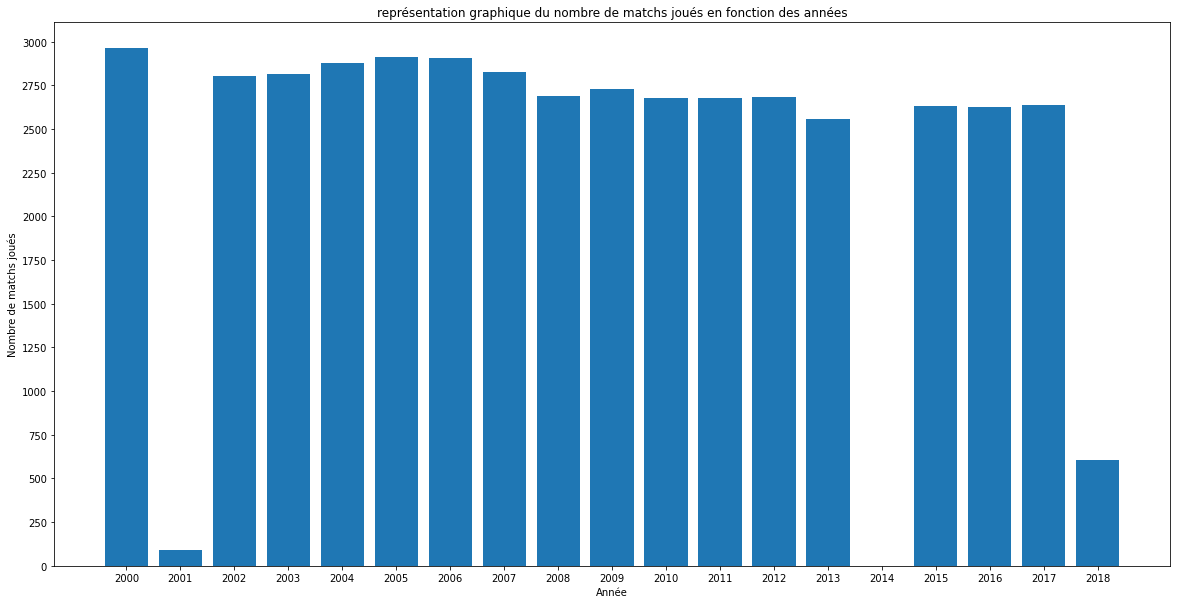

In [ ]:
display(df_atp['year'].value_counts())
plt.figure(figsize=(20,10))
plt.hist(df_atp['year'], rwidth=0.8, bins=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], align='left')
plt.title("représentation graphique du nombre de matchs joués en fonction des années")
plt.xlabel('Année')
plt.ylabel('Nombre de matchs joués')
plt.yticks(np.arange(0,3200,step=250))
plt.xticks(np.arange(2000,2019,step=1));

La représentation graphique précédente, nous montre que le nombre de matches joués annuel est globalement similaire sur l'ensemble du dataset à l'exception de l'année 2001 pour laquelle nous n'avons que 93 lignes de matches recensées.

Dans notre Dataset atp_data, la colonne'Winner' représente le gagnant du match joué, la colonne 'Loser' représente le perdant.
Affichons la représentation des 20 meilleurs gagnants de l'ensemble du dataset (2000-2018)

In [ ]:
#affichage du nombre moyen de match en excluant 2001 et 2018 qui semblent ne pas avoir été intégrées totalement dans le dataset d'origine

df_moy_match=df_atp[(df_atp['year']>2001) & (df_atp['year']<2018)]
print('nombre moyen de match par an:',df_moy_match['year'].value_counts().mean().round(0))

nombre moyen de match par an: 2736.0


In [ ]:
df_atp_2014= df_atp[df_atp['year']==2014]
print(df_atp_2014.head())
print("aucune donnée concernant l'année 2014 dans le dataset")

Empty DataFrame
Columns: [ATP, Location, Tournament, Date, Series, Court, Surface, Round, Best of, Winner, Loser, WRank, LRank, Wsets, Lsets, Comment, PSW, PSL, B365W, B365L, elo_winner, elo_loser, proba_elo, year]
Index: []

[0 rows x 24 columns]
aucune donnée concernant l'année 2014 dans le dataset


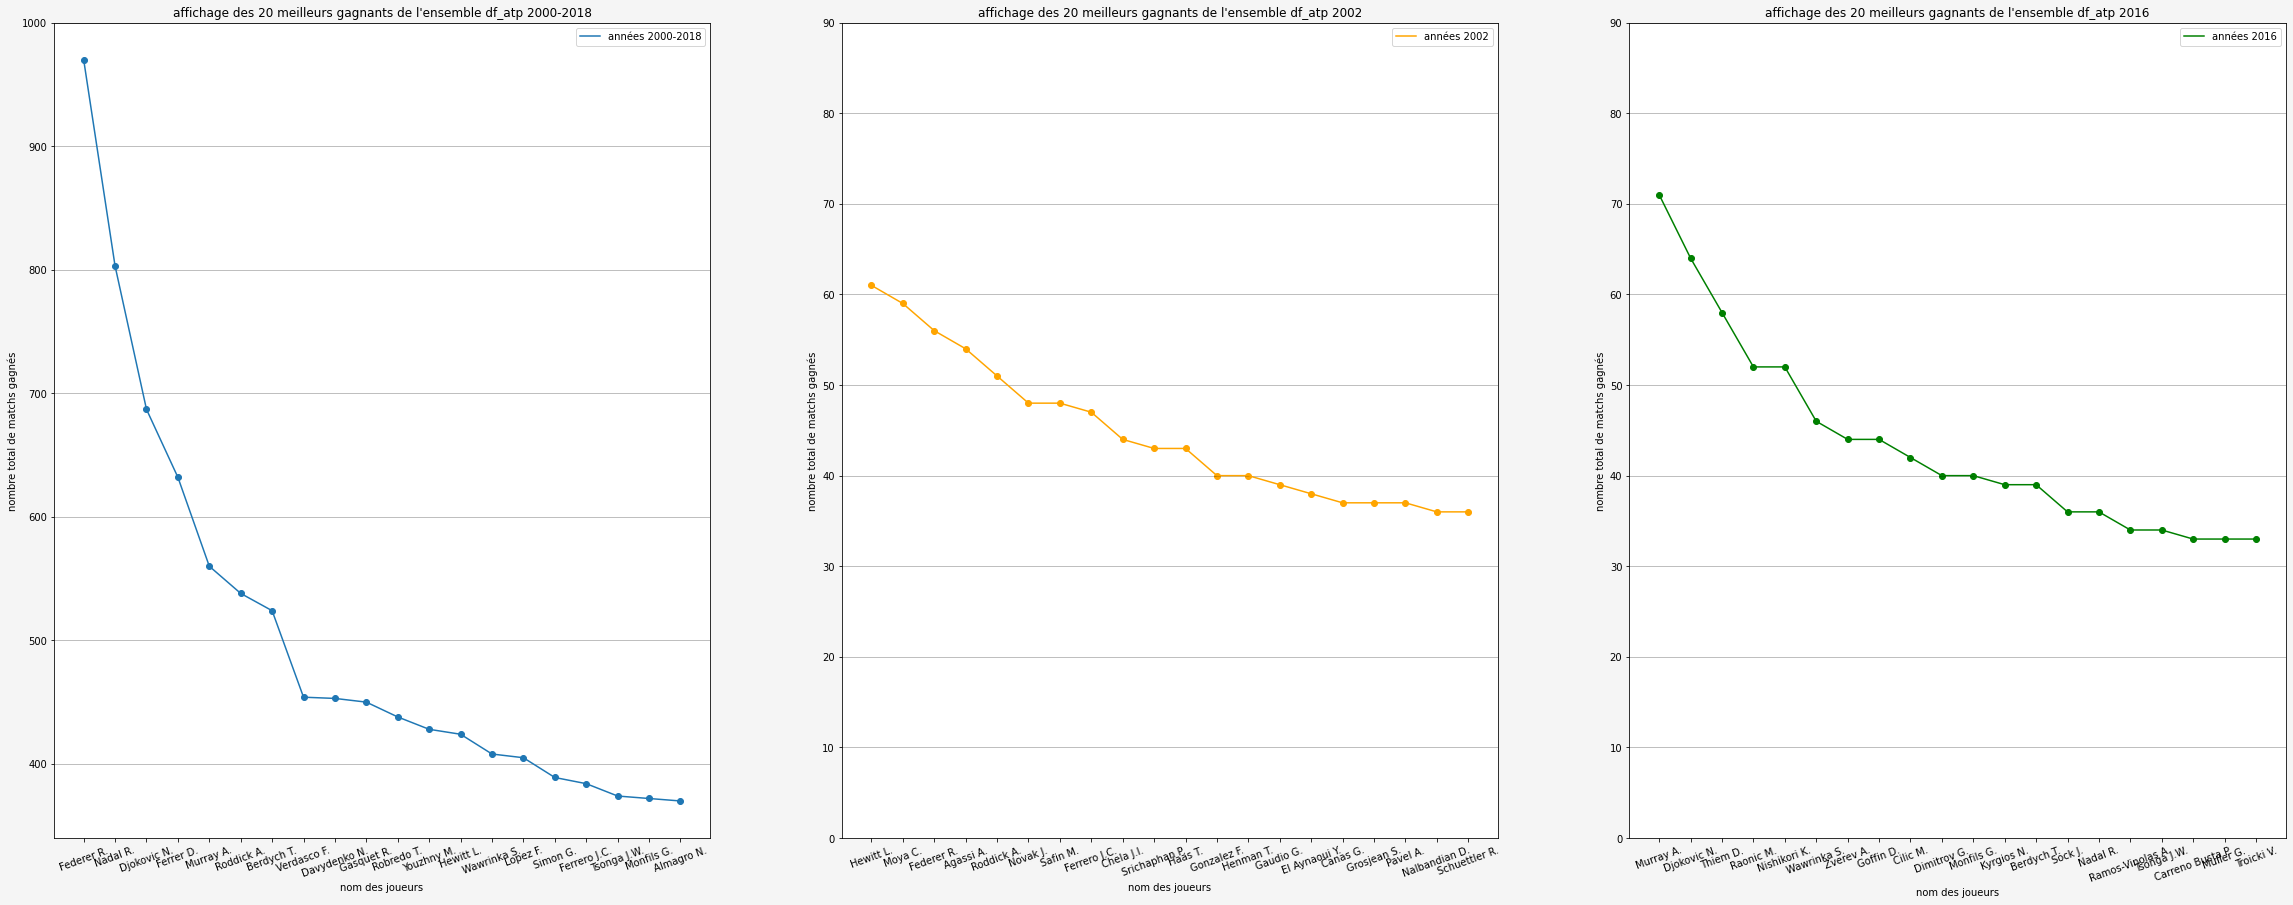

In [ ]:
#affichage d'un graphique des winner
df_atp_2002= df_atp[df_atp['year']==2002]
df_atp_2016= df_atp[df_atp['year']==2016]

fig=plt.figure(figsize=(40,15), facecolor='whitesmoke')
ax=fig.add_subplot(131)
plt.scatter(df_atp['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp['Winner'].value_counts(sort=True, ascending=False).head(20))
plt.plot(df_atp['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp['Winner'].value_counts(sort=True, ascending=False).head(20), label='années 2000-2018')
plt.title("affichage des 20 meilleurs gagnants de l'ensemble df_atp 2000-2018")
plt.xlabel("nom des joueurs")
plt.ylabel("nombre total de matchs gagnés")
plt.xticks(rotation=20)
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5, axis='y')

ax2=fig.add_subplot(132)
plt.scatter(df_atp_2002['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp_2002['Winner'].value_counts(sort=True, ascending=False).head(20), color='orange')
plt.plot(df_atp_2002['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp_2002['Winner'].value_counts(sort=True, ascending=False).head(20), label='années 2002', color='orange')
plt.yticks(np.arange(0, 100, step=10))
plt.xticks(rotation=20)
plt.title("affichage des 20 meilleurs gagnants de l'ensemble df_atp 2002")
plt.xlabel("nom des joueurs")
plt.ylabel("nombre total de matchs gagnés")
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5, axis='y')

ax3=fig.add_subplot(133)
plt.scatter(df_atp_2016['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp_2016['Winner'].value_counts(sort=True, ascending=False).head(20), color='green')
plt.plot(df_atp_2016['Winner'].value_counts(sort=True, ascending=False).index[0:20],df_atp_2016['Winner'].value_counts(sort=True, ascending=False).head(20), label='années 2016', color='green')
plt.yticks(np.arange(0, 100, step=10))
plt.xticks(rotation=20)
plt.title("affichage des 20 meilleurs gagnants de l'ensemble df_atp 2016")
plt.xlabel("nom des joueurs")
plt.ylabel("nombre total de matchs gagnés")
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5, axis='y')

Sur ces 3 graphiques des top20 nous pouvons observer quelques différences:
_ sur l'ensemble du dataset (graphe de gauche), les 7 premiers joueurs se détachent avec plus de 500 matches gagnés entre 2000 et 2018. les 13 suivants se situant entre 380 et 450 matches gagnés.
_ la comparaison entre top 20 de 2002 et top20 de 2016 nous montre une croissance du nombre de matches gagnés en 2016 pour les 2 premiers joueurs (Murray et Djokovic) et des écarts plus grands entre les 6 premiers joueurs de 2016 vs 2002 (env 26 matches d'écart en 2016 vs env 13 pour 2002).


Représentation du nombre de sets gagnés/perdus par match par le joueur Winner/Loser

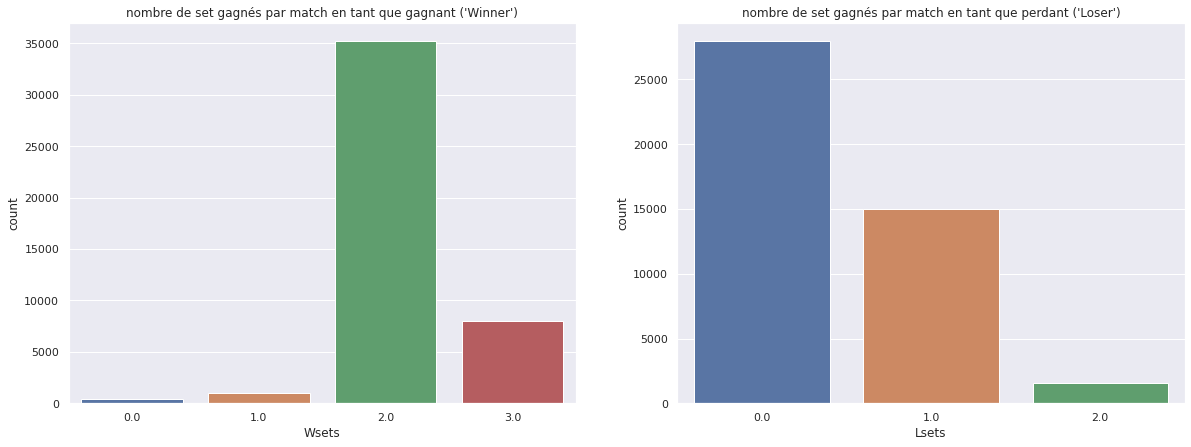

In [ ]:
#representation du nombre de set gagnant par match

sns.set_theme()
plt.figure(figsize=(20,7))
plt.subplot(121)
sns.countplot(x=df_atp['Wsets'])
plt.title("nombre de set gagnés par match en tant que gagnant ('Winner')")
plt.subplot(122)
sns.countplot(x=df_atp['Lsets'])
plt.title("nombre de set gagnés par match en tant que perdant ('Loser')");

Nous constatons que dans la majeure partie des matches joués, le gagnant  ('Winner') remporte avec 2 sets gagnés ou 3 sets gagnés (dans d'autres cas).

Quant au perdant ('Loser'), celui-ci perd en ne gagnant aucun set ou 1 set dans la plupart des cas (voire 2 sets dans une minorité de cas).

Pour mieux comprendre cette répartition, nous pouvons regarder le nombre de set maximum gagnés par match en fonction du type de tournoi

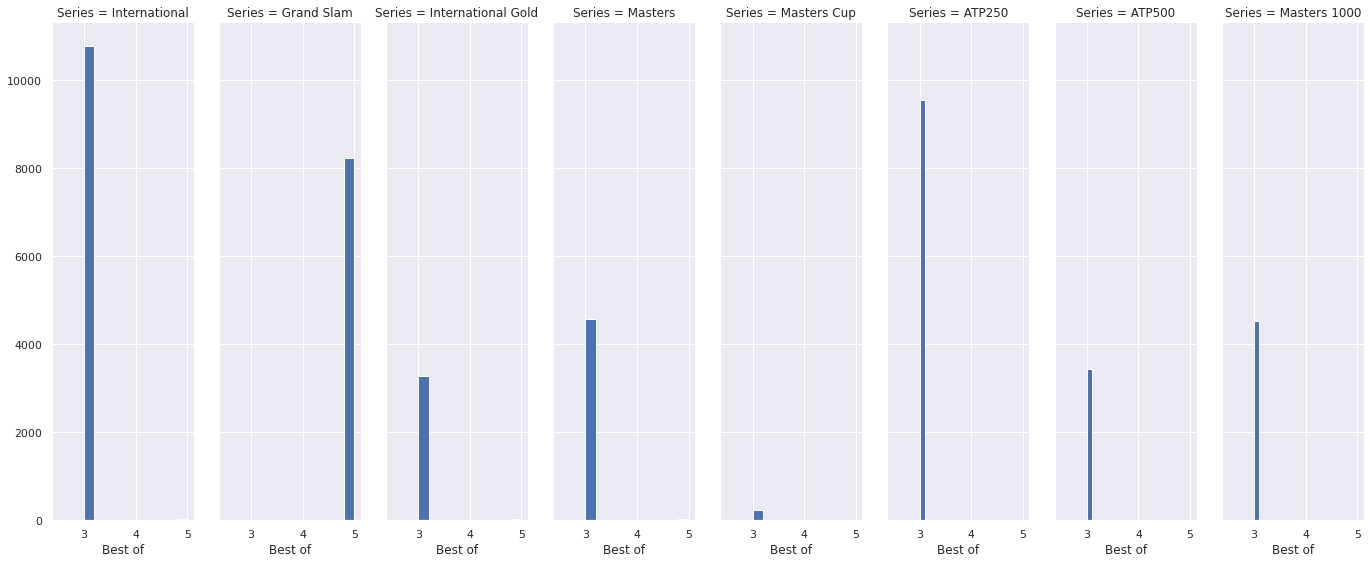

In [ ]:
#representation du nombre de set max (variable 'best of' qui prend 3 ou 5 en valeur) en fonction la categorie de tournoi

s=sns.FacetGrid(df_atp, col='Series', height=8, aspect=0.3)
s.map(plt.hist, 'Best of');

Cette représentation nous permet de comprendre que tous les tournois se jouent en maximum 3 sets (dont 2 gagnants), excepté les tournois Grand Chelem (Grand Slam) en maximum 5 sets (3 sets gagnants).
Nous remarquons également grâce à l'échelle des ordonnées partagés que le nombre de matches joués en 3 sets gagnants pour les tournois internationaux et pour les tournois ATP250 sont nettement supérieurs au nombre de matches en 3 sets gagnants pour les autres series disputées.
Ceci est dû au fait que plus les tournois type Masters (Cup, 1000) ainsi que ATP500 sont moins nombreux et plus prestigieux (plus de points ATP remportés et plus grande dote).
reference (https://fr.wikipedia.org/wiki/Cat%C3%A9gorisation_des_tournois_de_tennis#Depuis_1990)

Une visualisation de l'ensemble des variables peut être faite en analysant les variables numériques 2 par 2 (utilisation de la fonction PairGrid)

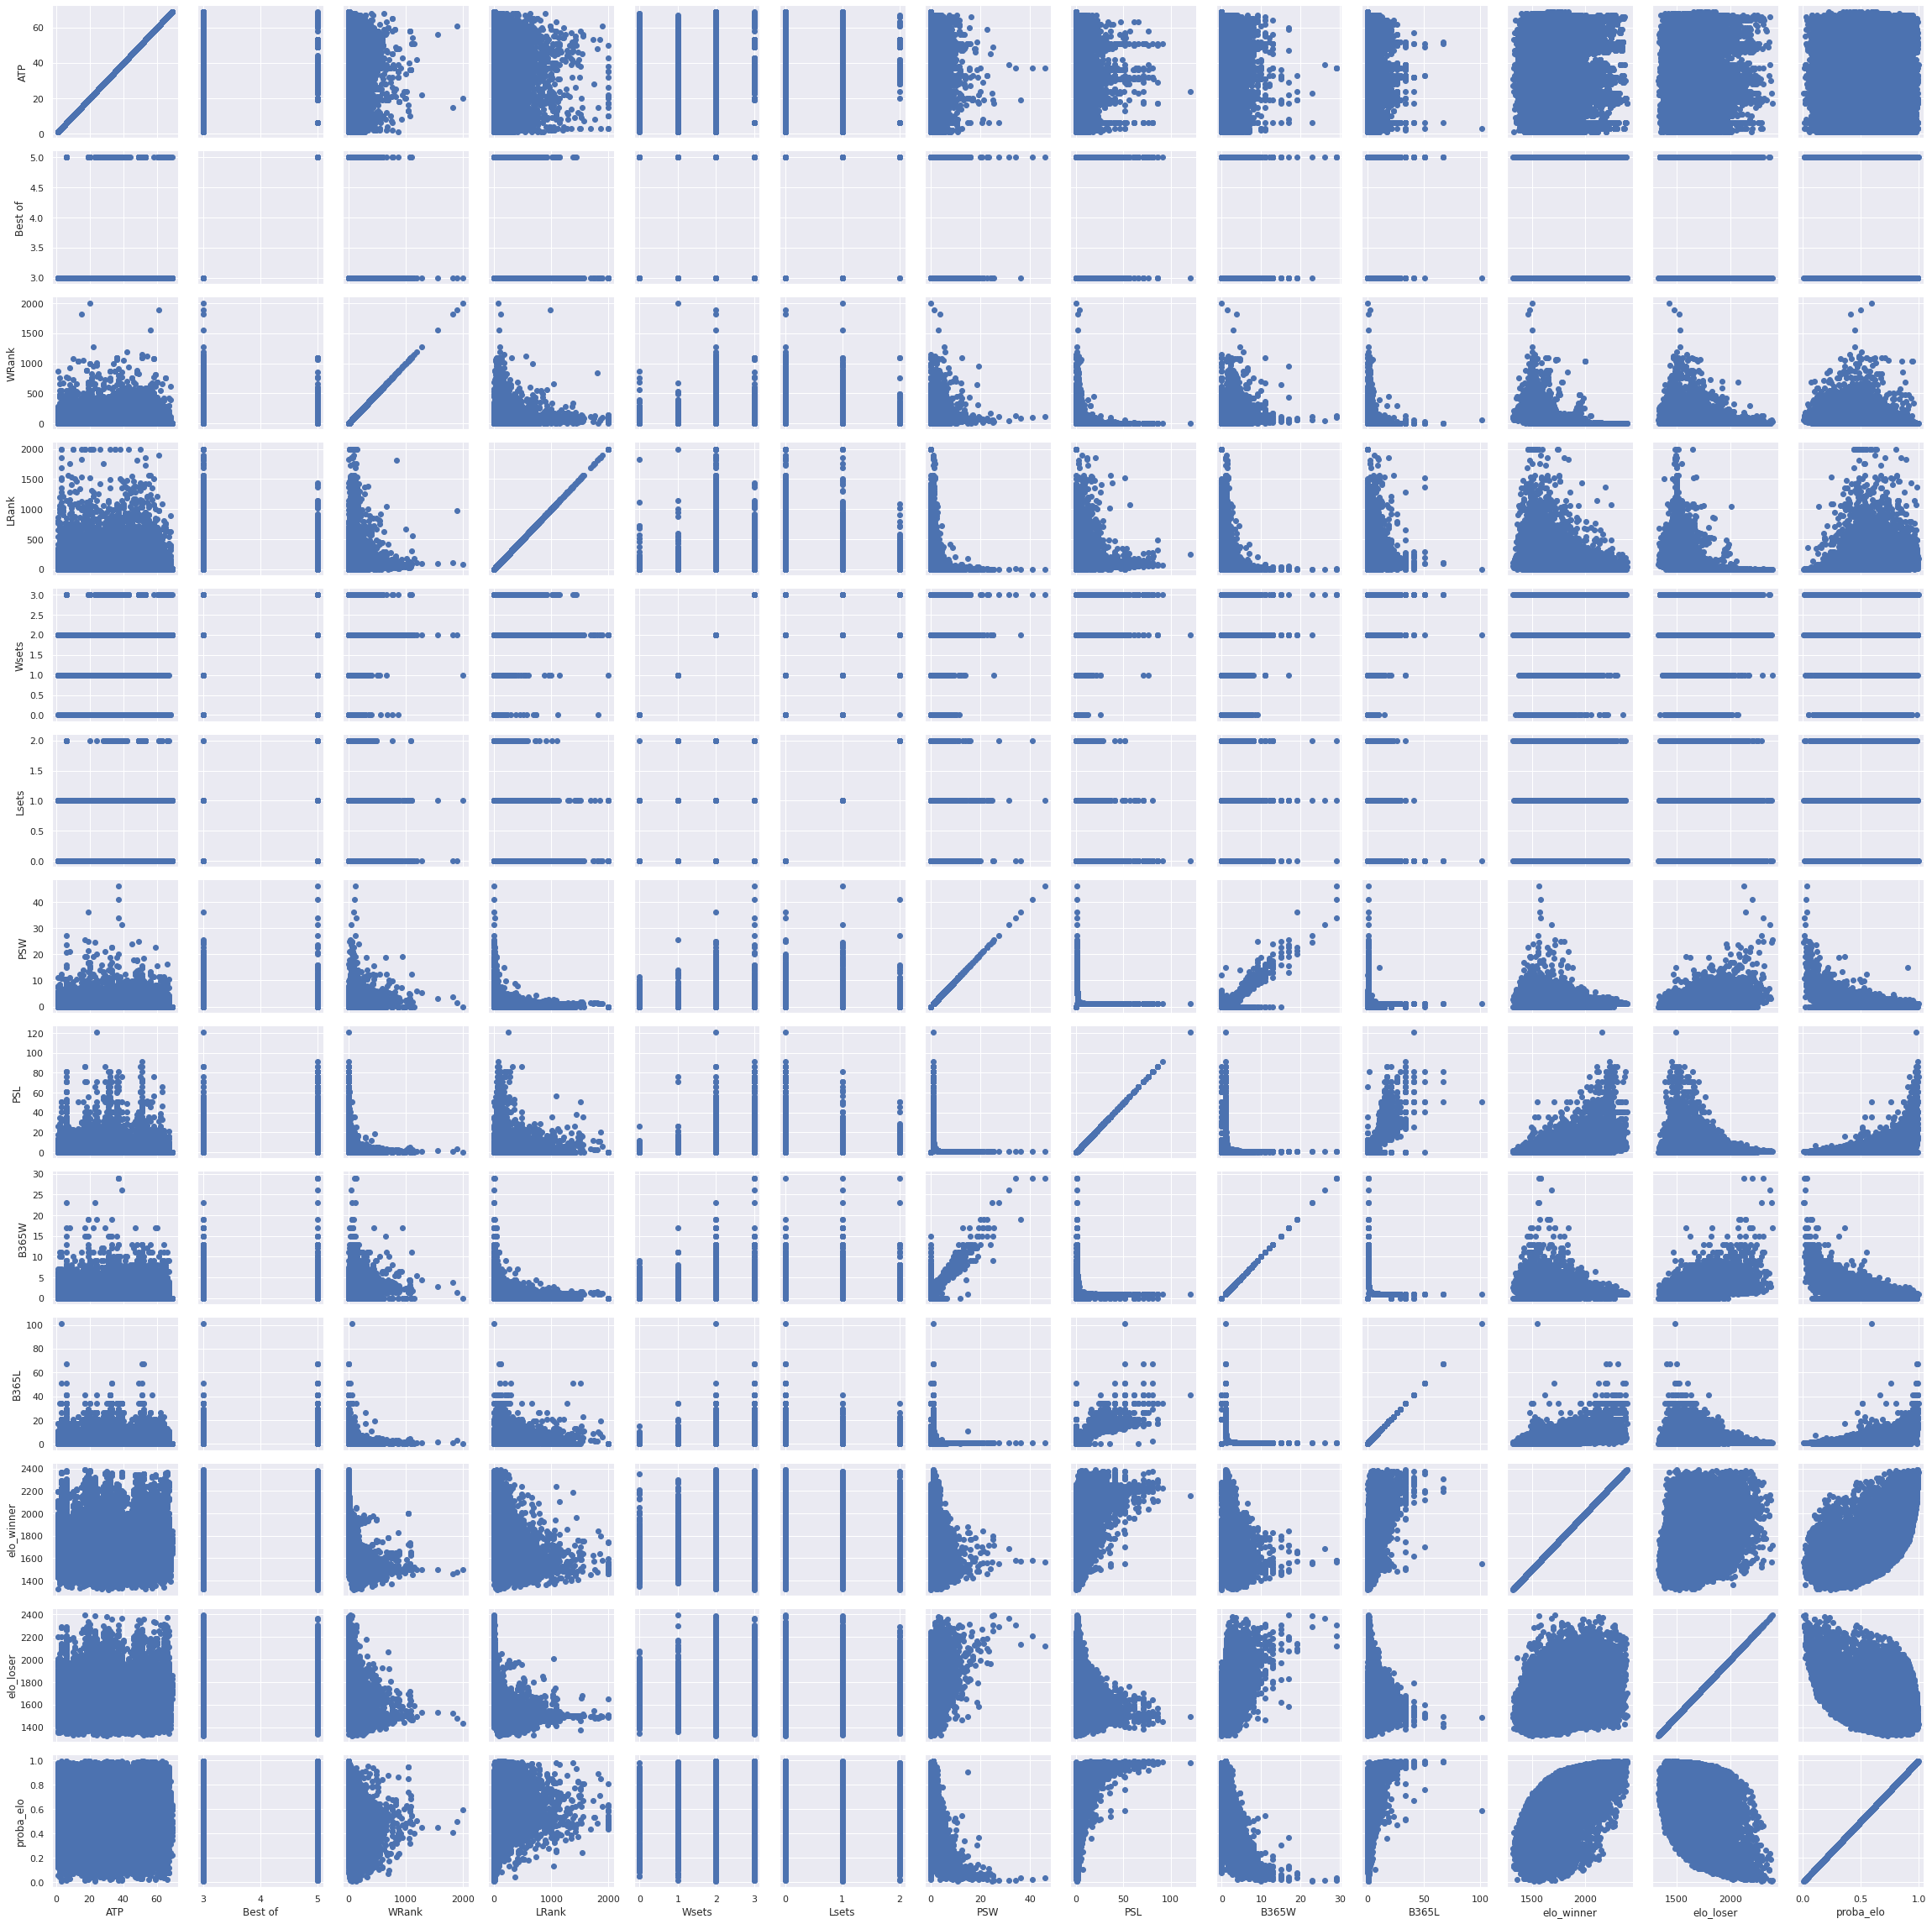

In [ ]:
#representation graphique des variables 2 par 2 en utilisant la fonction PairGrid
q=sns.PairGrid(df_atp)
q.map(plt.scatter);

Il est difficile de conclure sur des tendances, cependant, nous observons une symétrie entre la représentation du elo_winner en fonction de la proba_elo et la représentation du elo_loser en fonction de la proba_elo.

Nous constatons également une représentation assez linéaire de la variable B365W en fonction de PSW (il s'agit des côtes estimées pour les gagnants par nos 2 Bookmakers).

Faisons la représentation graphique de la relation entre le score elo du gagnant/perdant (elo_winner/elo_loser) en fonction du rang du joueur (WRank/LRank)

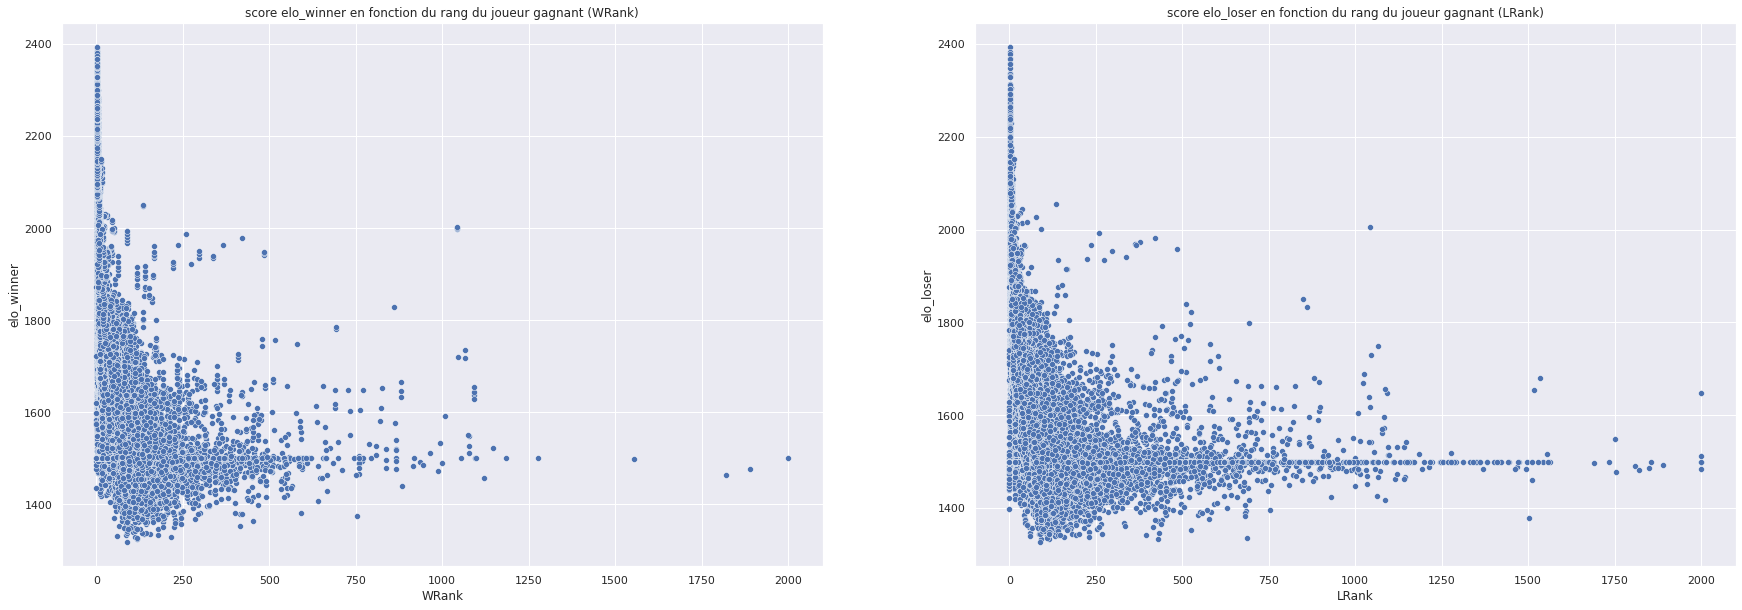

In [ ]:
#représentation graphique de la relation entre Wrank et elo_winner et LRank et elo_loser
plt.figure(figsize=(30,10))
plt.subplot(121)
sns.scatterplot(x='WRank', y='elo_winner', data=df_atp)
plt.title ("score elo_winner en fonction du rang du joueur gagnant (WRank)")
plt.subplot(122)
sns.scatterplot(x='LRank', y='elo_loser', data=df_atp)
plt.title ("score elo_loser en fonction du rang du joueur gagnant (LRank)");

Ce graphique nous permet de constater une répartition très similaire du score elo indépendemment du résultat du match (les graphes winner et loser étant similaires entre les les rangs 0 et 500). Cependant, nous constatons également sur le graphique de droite, qu'une grande partie des perdants a un score elo de 1500.



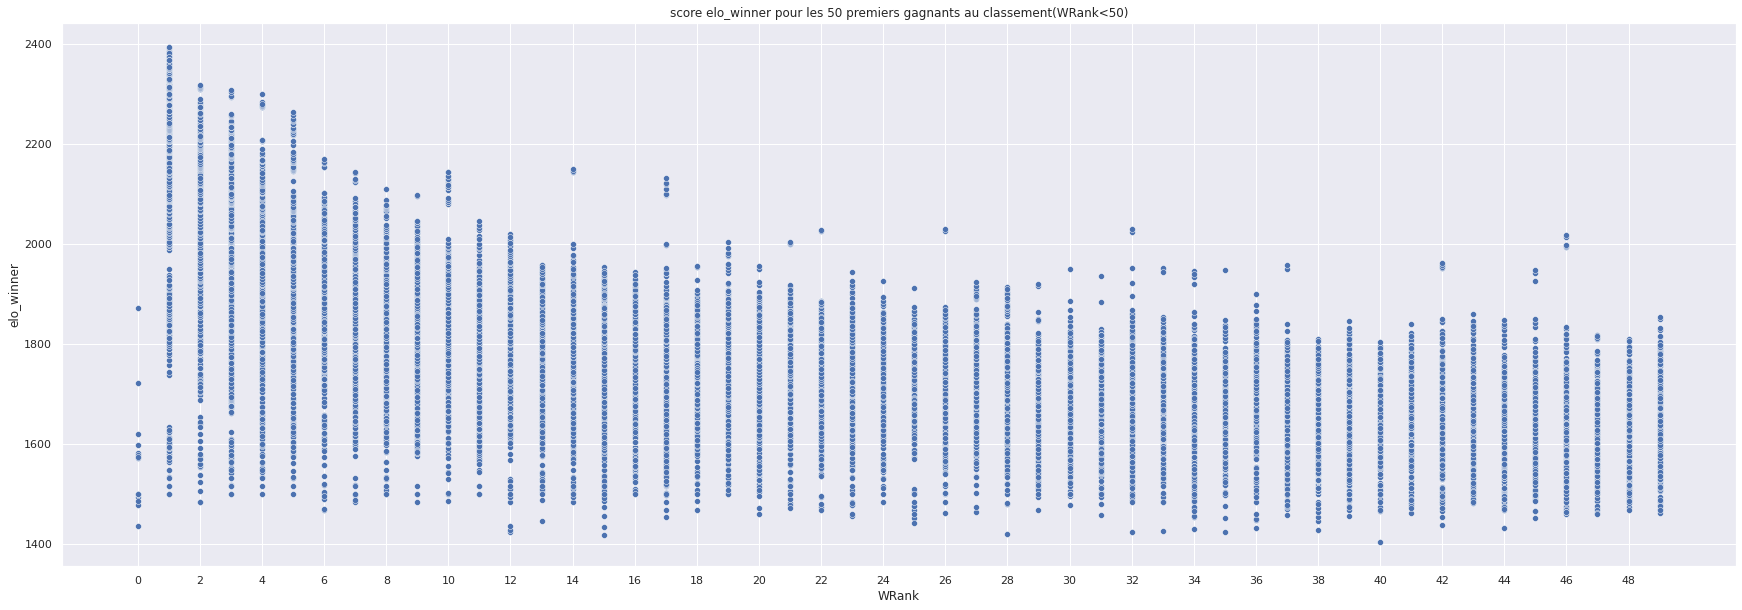

In [ ]:
#Zoom sur les 50 premiers WRank
df_atp_50=df_atp[df_atp['WRank']<50]

plt.figure(figsize=(30,10))
sns.scatterplot(x='WRank', y='elo_winner', data=df_atp_50)
plt.title ("score elo_winner pour les 50 premiers gagnants au classement(WRank<50)")
plt.xticks(np.arange(0,50, step=2));


In [ ]:
#affichage des modalités pour les gagnants ayant un classement WRank égal à 0
df_atp_0= df_atp[df_atp['WRank']==0]
DataFrameInfo(df_atp_0)

colonne= 0 ATP
8     3
47    2
1     2
34    1
3     1
7     1
53    1
22    1
23    1
35    1
41    1
Name: ATP, dtype: int64 
 nombre de modalités: 11 
 nombre de valeur nulle: 0
colonne= 1 Location
Washington          2
Adelaide            2
Vina del Mar        2
's-Hertogenbosch    1
Costa Do Sauipe     1
Doha                1
Montpellier         1
St. Petersburg      1
Houston             1
Monte Carlo         1
Stuttgart           1
Hamburg             1
Name: Location, dtype: int64 
 nombre de modalités: 12 
 nombre de valeur nulle: 0
colonne= 2 Tournament
Legg Mason Classic                     2
AAPT Championships                     2
Movistar Open                          2
Ordina Open                            1
Brasil Open                            1
Qatar Exxon Mobil Open                 1
Open Sud de France                     1
St. Petersburg Open                    1
U.S. Men's Clay Court Championships    1
Monte Carlo Masters                    1
Mercedes Cup        

In [ ]:
#affichage des noms de joueurs ayant un classement WRank=1
df_atp_1= df_atp[df_atp['WRank']==1]


In [ ]:
df_atp_1.groupby(['year','Winner']).agg({'elo_winner':['min','max']})


elo_winner             
                           min          max
year Winner                                
2000 Agassi A.     1500.000000  1633.681747
     Safin M.      1811.959224  1843.680886
2002 Hewitt L.     1737.639319  1868.804534
2003 Agassi A.     1858.827616  1898.839795
     Ferrero J.    1500.000000  1500.000000
     Ferrero J.C.  1866.488449  1908.373246
     Hewitt L.     1853.908751  1917.040954
     Roddick A.    1937.543655  1950.040628
2004 Federer R.    1987.564078  2137.809126
     Roddick A.    1910.610572  1933.654008
2005 Federer R.    2141.924564  2250.505199
2006 Federer R.    2210.619864  2278.562274
2007 Federer R.    2176.692260  2302.068719
2008 Federer R.    2105.859733  2209.250456
     Nadal R.      2155.108952  2198.200824
2009 Federer R.    2151.540461  2200.544823
     Federer R.    1500.000000  1548.000000
     Nadal R.      2108.262629  2237.583382
2010 Federer R.    2058.759008  2164.567100
     Nadal R.      2120.345799  2175.442620
2011 Djokovic N.   2246.040999  2300.891210
     Nadal R.      2099.179604  2219.539433
2012 Djokovic N.   2193.033869  2278.330121
     Federer R.    2225.820429  2264.165154
2013 Djokovic N.   2204.325420  2334.229704
     Nadal R.      2284.527051  2331.323732
2015 Djokovic N.   2263.303351  2366.419668
2016 Djokovic N.   2298.216862  2392.408923
     Murray A.     2237.666168  2258.556429
2017 Murray A.     2066.891137  2277.738398
     Nadal R.      2084.626060  2150.667670
2018 Nadal R.      2089.162703  2096.683796

Si nous représentons le score elo des gagnants en fonction de leur rang, du type de tournoi et de surface nous obtenons les graphiques suivants:

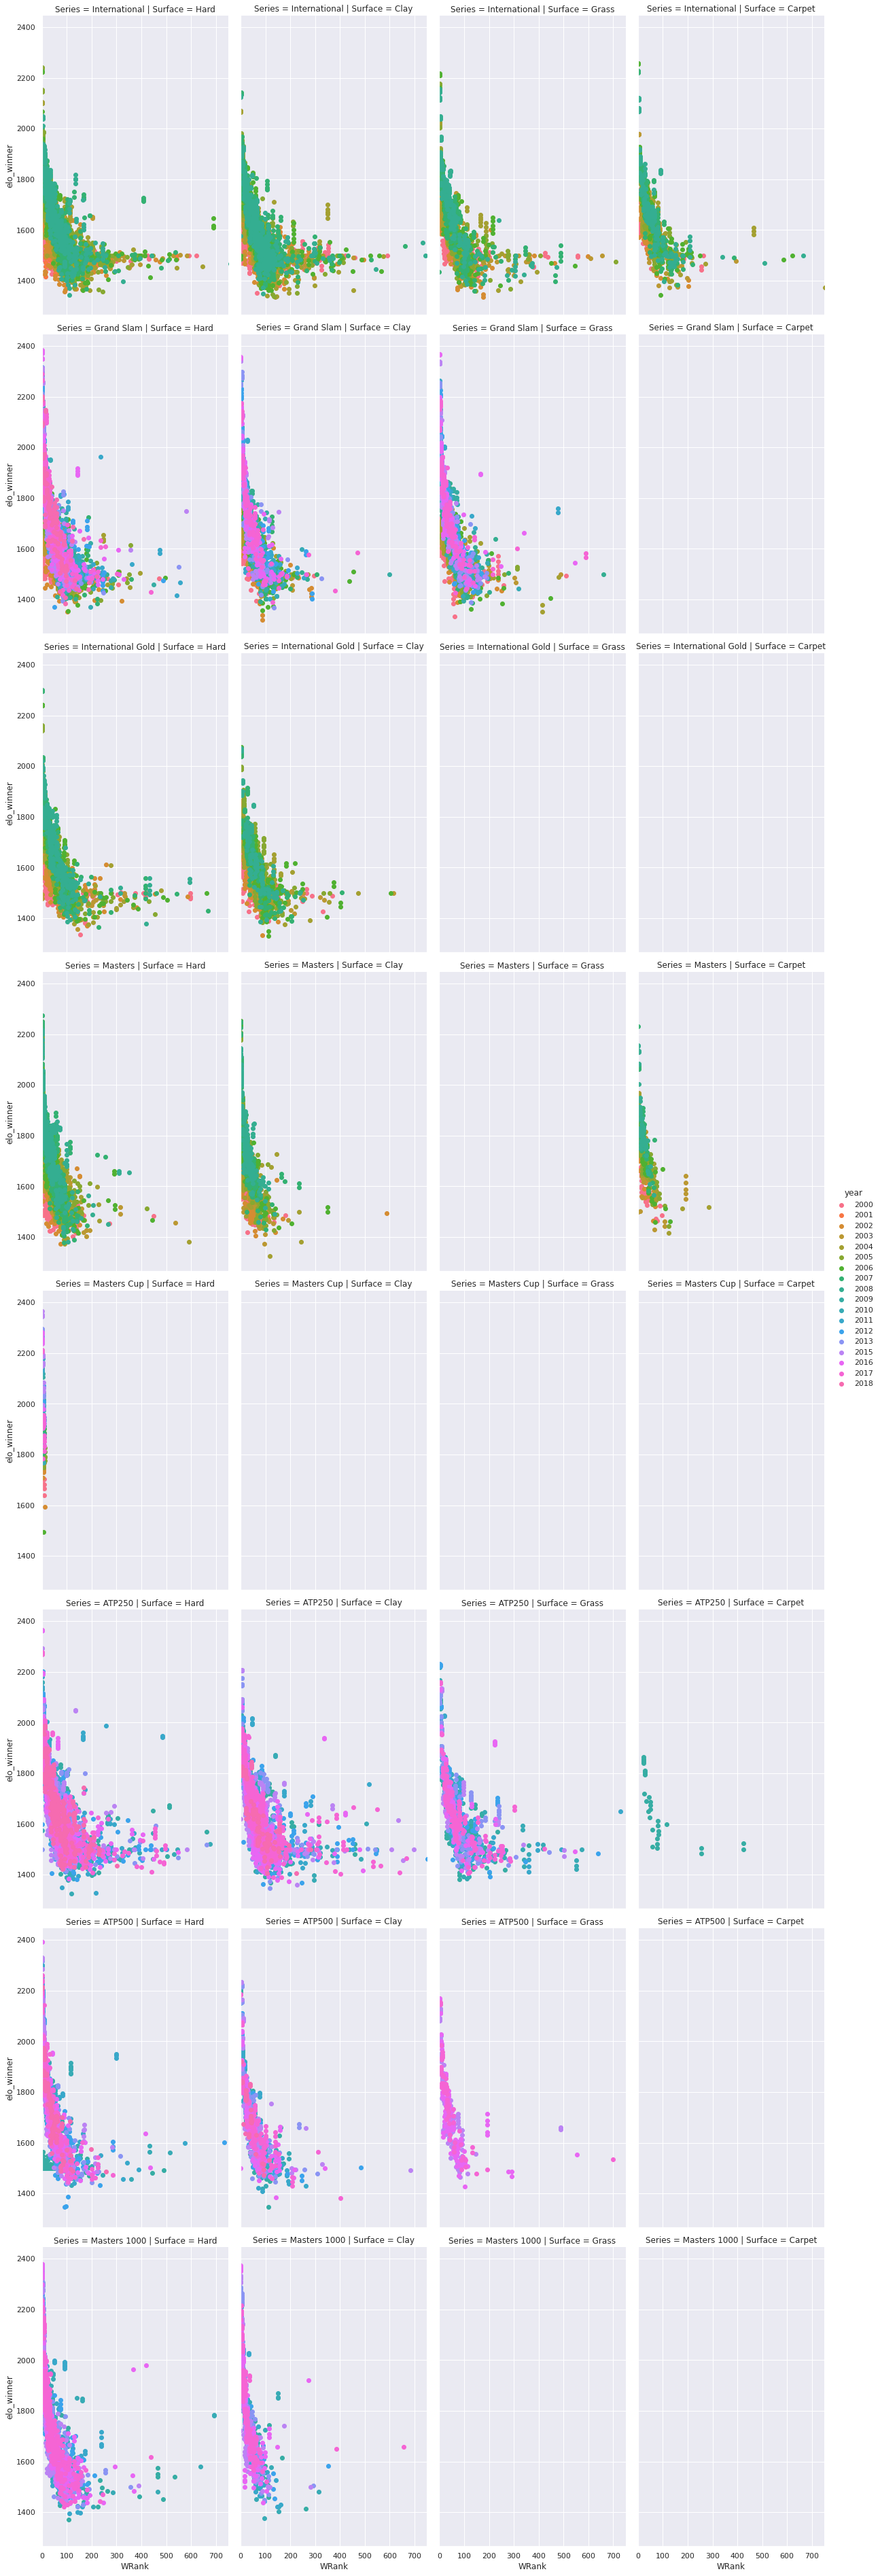

In [ ]:
#representation des elo_winner en fonction de leur rang, du type de tournoi et du type de surface

w=sns.FacetGrid(df_atp, row='Series', col='Surface', hue='year',height=6.6, aspect=.65)
w.map(plt.scatter, 'WRank', 'elo_winner')
w.add_legend()
plt.xlim(0,750);

Les graphiques obtenus ont des répartitions très similaires, nous constatons également que certains types de surface sont spécifiques a un type de tournoi (par ex: la moquette ('Carpet') n'existe pas pour les tournois Grand SLam, international Gold ou encore Masters 1000 et ATP500. La surface "dure" ('Hard') n'existe quant à elle que pour les Masters cup.

Les couleurs des années, nous permettent de constater qu'il existe une évolution de la représentation du type de surface en fonction des tournois. En effet, les Masters et Series international sont d'avantage présentent dans les années 2000 à 2009 (vert); les autres types de Series étant d'avantage représentés pour les années 2010 à 2018 (rose). Ceci nous permet de conclure que la dénomination des tournois (le type de Series) ainsi que les surfaces des terrains ont changé entre 2000 et 2018 (notamment fortement en 2009).

Nous contatons aussi que la moquette a disparu à partir de 2009 (aucun point rose sur les graphes), ce type de surface ayant été banni par l'ATP car trop exigeant (en entretien et pour les articulation des joueurs).


Evolution des types de tournois: (reference Wikipédia)

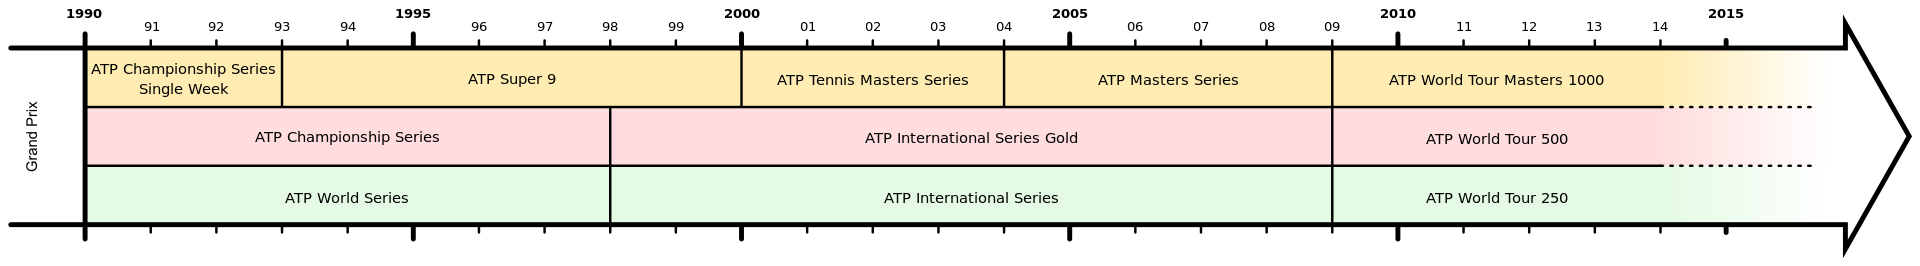

In [ ]:
carpet= df_atp[df_atp['Surface']=='Carpet']
display(carpet['year'].value_counts())
print("l'analyse précédente ainsi que la méthode value_counts sur la modalité 'Carpet' de la colonne 'Surface', nous permet de voir qu'un type de surface a disparu depuis 2009 (la moquette).")

2005    203
2004    202
2007    202
2008    202
2006    201
2002    171
2003    171
2000    140
2009     31
Name: year, dtype: int64

l'analyse précédente ainsi que la méthode value_counts sur la modalité 'Carpet' de la colonne 'Surface', nous permet de voir qu'un type de surface a disparu depuis 2009 (la moquette).


Performance des prédictions
Quel est le pourcentage de matchs predits correctement selon les différentes variables présentes dans le dataset

In [ ]:
df_atp_forviz=df_atp

In [ ]:
df_atp_forviz['Date']=pd.to_datetime(df_atp_forviz['Date'], yearfirst=True)

In [ ]:
#utilisation de la fonction établie par edouard Thomas (beat the bookmaker notebook from kaggle)
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=120)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

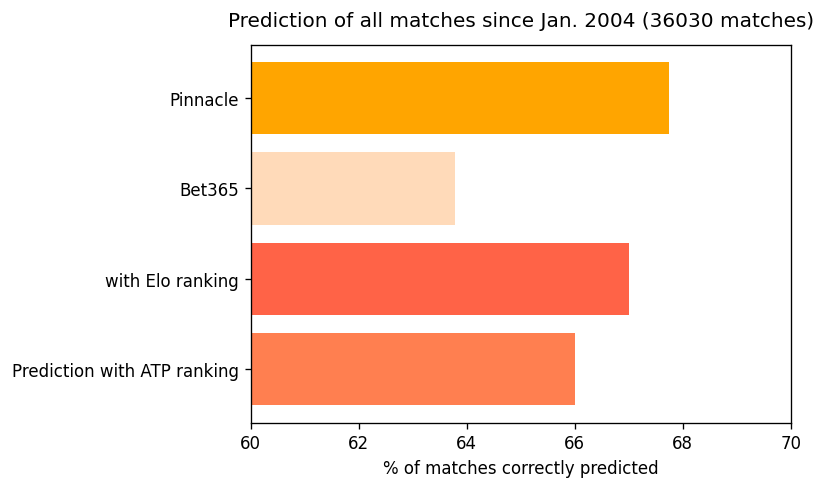

In [ ]:
#application de la fonction établie par edouard thomas sur notre dataset copié df_atp_forviz

# Comparison of different techniques for the winner prediction
# Interval for the comparison : [beg,end]
beg=datetime(2004,1,1)
end=df_atp_forviz.Date.iloc[-1]
indices=df_atp_forviz[(df_atp.Date>=beg)&(df_atp_forviz.Date<=end)].index
# classical ATP ranking
test=df_atp_forviz[["WRank","LRank"]].iloc[indices,:]
atp=100*(test.LRank>test.WRank).sum()/len(indices)
# Elo ranking
test=df_atp_forviz.iloc[indices,:]
elo=100*(test.elo_winner>test.elo_loser).sum()/len(indices)
# Bookmakers
test=df_atp_forviz.iloc[indices,:]
book_pi=100*(test.PSW<test.PSL).sum()/len(indices)
book_365=100*(test.B365W<test.B365L).sum()/len(indices)

# Plot
labels=["Prediction with ATP ranking","with Elo ranking",
        "Bet365","Pinnacle"]
values=[atp,elo,book_pi,book_365]
xaxis_label="% of matches correctly predicted"
title="Prediction of all matches since Jan. 2004 ("+str(len(indices))+" matches)"
xlim=[60,70]
basic_horizontal_barplot(values,labels,xaxis_label,title,xlim,figsize=(4.5,3.5))

## **Etape 2: Modélisation**
  1.   **Préparation et modélisation des données**
  

**1.1 Encodage des variables catégorielles**




Encodage des variables catégorielles pour ne pas avoir un dataFramme volumineux: 
>> * La variable “Date”: Année / Mois 

>>Toutes les variables catégorielles ordinales peuvent être remplacées par des nombres qui vont leur attribuer un ordre:
  * Surface (Carpet: 0, Clay:1 , Grass:2 , Hard:3  ) 
  * Round  (1,2, 3,4,5,6,7,8 correspondent aux différents niveaux de round)
  * Comment ( Completed: 1 , Disqualified: 0, Retired: -1 , Walkover: -2 ) 
  * Court (Indoor: 0 , Outdoor: 1)
  * Regrouper “Location” & “Tournament” en catégorie de tournois (Grand Chelem,Masters ,Masters 1000 , ATP 500 , ATP 250 ) 
  >>Ensuite pour chaque catégorie de tournois attribuer une valeur numérique: 
    * Grand Chelem : 2500,
    * Masters : 1500 ,
    * Masters 1000 :1000,
    * ATP 500 : 500 , 
    * ATP 250 : 250

Il serait intéressant de comparer les résultats  des modèles avec encodages et sans encodages des variables catégorielles. 

* Les cotations des bookmakers vont être stocké dans un autre dataFrame car elles nous servira à comparer nos résultats


In [ ]:
#Séparé la "Date" en "Année" & "Mois"
def split_a(annee):
  sep =annee.split('-')
  annee = sep[0]
  return annee

def split_m(mois):
  sep =mois.split('-')
  mois = sep[1]
  return mois

Annee  = df_atp['Date'].apply(split_a)
Mois  = df_atp['Date'].apply(split_m)
df_atp['Annee'] = Annee
df_atp['Mois']= Mois
df_atp['Annee'] = df_atp['Annee'].astype('int64')
df_atp['Mois'] = df_atp['Mois'].astype('int64')

#Traitement des variables catégorielles: Surface (Carpet: 0, Clay:1 , Grass:2 , Hard:3 )
display(df_atp['Surface'].value_counts())

#np.NaN:'WO'
surface={'Carpet': 0, 'Clay':1 , 'Grass':2 , 'Hard':3}
df_atp['surface'] = df_atp['Surface'].replace(surface)

#Round (1,2, 3,4,5,6,7,8 correspondent aux différents niveaux de round)
display(df_atp['Round'].value_counts())
round ={'1st Round': 1,
        '2nd Round': 2,
        '3rd Round': 3,
        '4th Round': 4,
        'Quarterfinals': 5,
        'Semifinals': 6,
        'The Final': 7,
        'Round Robin':8}
df_atp['round'] = df_atp['Round'].replace(round)

#Comment ( Completed: 1 , Disqualified: 0, Retired: -1 , Walkover: -2 )
comment = {'Completed': 1 , 'Disqualified': 0, 'Retired': -1 , 'Walkover': -2}
df_atp['comment'] = df_atp['Comment'].replace(comment)

#Court (Indoor: 0 , Outdoor: 1)
court = {'Indoor': 0 , 'Outdoor': 1}
df_atp['court'] = df_atp['Court'].replace(court)

#Chaque "Series" regroupe un ensemble de tournois et on peut directement avec le niveau de répartition des différents tournois
#Grand Chelem : 2000, Masters : 1500 ,Masters 1000 :1000,ATP 500 : 500 ,ATP 250 : 250 et plus
#Un tournois peut être joué dans plusieurs séries donc juste faire un get dummies pour cette variables 

display(df_atp['Series'].value_counts())

series = {
          'International Gold':3500,
          'International':3000,     
          'Grand Slam':2500,
          'Masters Cup':2000 ,         
          'Masters':1500 ,              
          'Masters 1000':1000 ,         
          'ATP500':500 , 
          'ATP250':250 }               

df_atp['series'] = df_atp['Series'].replace(series)


Hard      23799
Clay      14470
Grass      4916
Carpet     1523
Name: Surface, dtype: int64

1st Round        20728
2nd Round        12320
Quarterfinals     4240
3rd Round         3128
Semifinals        2152
The Final         1076
4th Round          752
Round Robin        312
Name: Round, dtype: int64

International         10792
ATP250                 9550
Grand Slam             8255
Masters                4616
Masters 1000           4528
ATP500                 3433
International Gold     3294
Masters Cup             240
Name: Series, dtype: int64

>> Après un retaitrement des données catégorielles suivantes: 
*   Date
*   Surface
*   Round
*   Comment
*   Court
*   Series: un tournois peut appartenir à plusieurs séries => On peut conserver le "tournament" est le normaliser à l'aide du get_dummies
*   Location n'apporte pas plus d'information. On peut le supprimer?! ou bien le conserver et effectuer une normalisation.


**1.2 Identifiant unique pour un match & un joueur**



In [ ]:
#création de l'identifiant match
df_atp['index'] = df_atp.index 
df_atp['match_id'] = df_atp['index'] + 10000
df_atp['match_id'].nunique

#Split winner & loser
df_winner = df_atp[['match_id','WRank','Winner']]
df_loser = df_atp[['match_id','LRank','Loser']]

#Ajustement des dataFrrame winner & loser
df_winner = df_winner.rename(columns={'Winner':'Player','WRank':'Rank'})
df_loser = df_loser.rename(columns={'Loser':'Player','LRank':'Rank'})
df_winner['Player_cible'] = 1
df_loser['Player_cible'] = 0

#Concaténation winner & loser
df_player = pd.concat([df_winner, df_loser])
df_player = df_player
#df_player

#création de l'identifiant joueur
joueur_unique = df_player['Player'].unique()
df_joueur = pd.DataFrame(joueur_unique,columns=['Player'])
df_joueur['index'] = df_joueur.index 
df_joueur['Player_id'] = df_joueur['index'] + 1000
df_joueur = df_joueur.drop('index', axis=1)
#df_joueur

#fusion des identifiants match & joueurs
df_player_id = df_joueur.merge(df_player, how ='left' , on ='Player' )
display(df_player_id.info())
#display(df_player_id.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89415
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Player        89416 non-null  object
 1   Player_id     89416 non-null  int64 
 2   match_id      89416 non-null  int64 
 3   Rank          89416 non-null  int64 
 4   Player_cible  89416 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.1+ MB


None

**1.3 DataFrame Finale**

In [ ]:
#Fusion df_atp & df_player_id (= identifiant match & joueurs)
df_atp_encodage = df_atp.merge(df_player_id, how ='left' , on ='match_id')

#Trie par ordre croissant sur la Date
df_atp_encodage = df_atp_encodage.sort_values(by ='Date' , ascending = True)

#Suppression des variables
colonne_a_supp = ['Date','Round','Surface','Comment','Court','Series','Player','Wsets','Lsets', 
                  'proba_elo','Best of', 'WRank','LRank', 'Winner','Loser', 'index','match_id']
df_atp_final = df_atp_encodage.drop(colonne_a_supp, axis = 1)

#Normalisation de Tournois & Location
#df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Tournament'], prefix= 'tournois'))
#df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Location'], prefix= 'loc'))
#df_atp_final = df_atp_final.drop(['Tournament','Location'], axis = 1)

#df_atp_final.info()

df_atp_final = df_atp_final.fillna(0)
df_atp_final.isna().sum()

df_atp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89415
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ATP           89416 non-null  int64  
 1   Location      89416 non-null  object 
 2   Tournament    89416 non-null  object 
 3   PSW           89416 non-null  float64
 4   PSL           89416 non-null  float64
 5   B365W         89416 non-null  float64
 6   B365L         89416 non-null  float64
 7   elo_winner    89416 non-null  float64
 8   elo_loser     89416 non-null  float64
 9   Annee         89416 non-null  int64  
 10  Mois          89416 non-null  int64  
 11  surface       89416 non-null  int64  
 12  round         89416 non-null  int64  
 13  comment       89416 non-null  int64  
 14  court         89416 non-null  int64  
 15  series        89416 non-null  int64  
 16  Player_id     89416 non-null  int64  
 17  Rank          89416 non-null  int64  
 18  Player_cible  89416 non-nu

In [ ]:
df_atp_final.columns

**1.4 Moyenne Roulante**

In [ ]:
#Fonction de moyenne roulante
def moyenne_roulante(df, n=4):
    if 'match_id' in df.columns : 
        team_id ='match_id'
        date ='Date'
        
    df = df.sort_values(by=[team_id, date]).reset_index(drop=True)
    
    df_roulante = pd.DataFrame()
    
    for i in range(1, len(df)): 
            for colname in df.columns[[0,1,2,3,4,5,6]]:
                df_roulante.loc[i, colname] = df.loc[i, colname]

            df_roulante.loc[i, df.columns[7]] = df.loc[max(0, i-n):(i-1), df.columns[7]].mean()
            for colname in df.columns[7:]:
                df_roulante.loc[i, colname] = df.loc[max(0, i-n):(i-1), colname].mean()
                
    return df_roulante

In [ ]:
#Préparation df pour la moyenne mobile

#Fusion df_atp & df_player_id (= identifiant match & joueurs)
df = df_atp.merge(df_player_id, how ='left' , on ='match_id')

#Trie par ordre croissant sur la Date
df = df.sort_values(by ='Date' , ascending = True)

#Suppression des variables sauf Date pour le calcul de la moyenne mobile
colonne_a_supp = ['Round','Surface','Comment','Court','Series','Player','Wsets','Lsets', 
                  'proba_elo','Best of', 'WRank','LRank','Winner','Loser','index']
df = df.drop(colonne_a_supp, axis = 1)

#Normalisation de Tournois & Location
#df = df.join(pd.get_dummies(df['Tournament'], prefix= 'tournois'))
#df = df.join(pd.get_dummies(df['Location'], prefix= 'loc'))
df = df.drop(['Tournament','Location'], axis = 1)

#Ordre des variables:
col_0 = df.pop('Date')
df.insert(0, 'Date', col_0)
col_1 = df.pop('Annee')
df.insert(1, 'Annee', col_1)
col_2 = df.pop('Mois')
df.insert(2, 'Mois', col_2)
col_3 = df.pop('match_id')
df.insert(3, 'match_id', col_3)
col_4 = df.pop('Player_id')
df.insert(4, 'Player_id', col_4)
col_5 = df.pop('Player_cible')
df.insert(5, 'Player_cible', col_5)

#Application de la moyenne mobile sur df = le dataFrame avec l'ensemble des variables après encodage 
df_atp_moyenne_mobile = moyenne_roulante(df)
#df_atp_moyenne_mobile

#Ajouter les get_dummies
df_atp_moyenne_mobile = df_atp_moyenne_mobile.join(pd.get_dummies(df_atp_encodage['Tournament'], prefix= 'tournois'))
df_atp_moyenne_mobile = df_atp_moyenne_mobile.join(pd.get_dummies(df_atp_encodage['Location'], prefix= 'loc'))
df_atp_moyenne_mobile = df_atp_moyenne_mobile.fillna(0)
df_atp_moyenne_mobile.isna().sum()

df_atp_moyenne_mobile.info()

#temps d'exécution: 45 min 17 s

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89415 entries, 1 to 89415
Columns: 341 entries, Date to loc_Zagreb
dtypes: float64(18), object(1), uint8(322)
memory usage: 43.1+ MB


In [ ]:
df_atp_moyenne_mobile['Player_cible'].value_counts()

**2.2 Classification sans hyperparamètres**

les classifieurs sélectionnés pour notre modélisation sont:
    

1.   LogisticRegression
2.   KNeighbors
1.   RandomForest







# Modélisation sans moyenne mobile

## **modélisation 1**

In [ ]:
#Normalisation de Tournois & Location
df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Tournament'], prefix= 'tournois'))
df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Location'], prefix= 'loc'))
df_atp_final = df_atp_final.drop(['Tournament','Location'], axis = 1)

In [ ]:
# séparation des variables explicatives (data#) de la variable cible (target#)
target = df_atp_final['Player_cible']
data= df_atp_final.drop('Player_cible', axis = 1)

In [ ]:
#séparation de la base de données en base d'entrainement (X_train,y_train) et base de test (X_test, y_test). la base d'entrainement représente 20% de la taille de la bdd totale (test_size=0.2).
#shuffle=False correspond à la sélection des lignes par ordre chronologique
#random_state=66 permet de fixer la sélection aléatoire
X_train, X_test, y_train, y_test = train_test_split(data, target , test_size = 0.2, random_state = 66, shuffle = False)

In [ ]:
#instanciation des classifieurs (clf1, knn1, rf1)
clf1= linear_model.LogisticRegression ()
knn1= neighbors.KNeighborsClassifier()
rf1= RandomForestClassifier()

In [ ]:
#entrainement des classifieurs
clf1.fit(X_train, y_train)
knn1.fit(X_train, y_train)
rf1.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
#prédiction et affichage des matrices de confusions pour chaque modèle
y_pred1_clf1 = clf1.predict(X_test)
y_pred1_knn1 = knn1.predict(X_test)
y_pred1_rf1 = rf1.predict(X_test)

In [ ]:
#affichage des matrices de confusion
cm1_clf1 = pd.crosstab(y_test, y_pred1_clf1 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
cm1_knn1 = pd.crosstab(y_test, y_pred1_knn1 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
cm1_rf1 = pd.crosstab(y_test, y_pred1_rf1 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
display('Matrice de confusion modele LogisticRegression:', cm1_clf1)
display('Matrice de confusion modele KNN:', cm1_knn1)
display('Matrice de confusion modele RandomForest:', cm1_rf1)

'Matrice de confusion modele LogisticRegression:'

Classe prédite,0,1
Classe réelle,,
0,0.365355,0.134645
1,0.253411,0.246589


'Matrice de confusion modele KNN:'

Classe prédite,0,1
Classe réelle,,
0,0.366752,0.133248
1,0.173283,0.326717


'Matrice de confusion modele RandomForest:'

Classe prédite,0,1
Classe réelle,,
0,0.427142,0.072858
1,0.164337,0.335663


In [ ]:
#affichage des scores des 3 modèles:
display('le score pour le modèle RegressionLogistic est:', clf1.score(X_test, y_test))
display('le score pour le modèle KNN est:', knn1.score(X_test, y_test))
display('le score pour le modèle RandomForest est:', rf1.score(X_test, y_test))

'le score pour le modèle RegressionLogistic est:'

0.6119436367702975

'le score pour le modèle KNN est:'

0.6934690225900246

'le score pour le modèle RandomForest est:'

0.7628047416685305

**Modelisation 2**

**standardisation avec minMax scaler**

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#instanciation des classifieurs 
clf2= linear_model.LogisticRegression ()
knn2= neighbors.KNeighborsClassifier()
rf2= RandomForestClassifier()

In [ ]:
#entrainement des classifieurs
clf2.fit(X_train_scaled, y_train)
knn2.fit(X_train_scaled, y_train)
rf2.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RandomForestClassifier()

In [ ]:
#prédiction et affichage des matrices de confusions pour chaque modèle
y_pred2_clf2 = clf2.predict(X_test_scaled)
y_pred2_knn2 = knn2.predict(X_test_scaled)
y_pred2_rf2 = rf2.predict(X_test_scaled)

In [ ]:
#affichage des matrices de confusion
cm2_clf2 = pd.crosstab(y_test, y_pred2_clf2 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
cm2_knn2 = pd.crosstab(y_test, y_pred2_knn2 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
cm2_rf2 = pd.crosstab(y_test, y_pred2_rf2 , rownames=['Classe réelle'], colnames =['Classe prédite'], normalize= True)
display('Matrice de confusion modele LogisticRegression:', cm2_clf2)
display('Matrice de confusion modele KNN:', cm2_knn2)
display('Matrice de confusion modele RandomForest:', cm2_rf2)

'Matrice de confusion modele LogisticRegression:'

Classe prédite,0,1
Classe réelle,,
0,0.225565,0.274435
1,0.123742,0.376258


'Matrice de confusion modele KNN:'

Classe prédite,0,1
Classe réelle,,
0,0.310445,0.189555
1,0.223608,0.276392


'Matrice de confusion modele RandomForest:'

Classe prédite,0,1
Classe réelle,,
0,0.417860,0.082140
1,0.137721,0.362279


In [ ]:
#affichage des scores des 3 modèles:
display('le score pour le modèle RegressionLogistic est:', clf2.score(X_test_scaled, y_test))
display('le score pour le modèle KNN est:', knn2.score(X_test_scaled, y_test))
display('le score pour le modèle RandomForest est:', rf2.score(X_test_scaled, y_test))

'le score pour le modèle RegressionLogistic est:'

0.6018228584209349

'le score pour le modèle KNN est:'

0.5868373965555804

'le score pour le modèle RandomForest est:'

0.780138671438157

Evaluation des modèles sans hyperparamètres

In [ ]:
print('le rapport de classification pour LogisticRegression est:', '\n',classification_report(y_test, y_pred1_clf1))
print('le rapport de classification pour KNN est:', '\n',classification_report(y_test, y_pred1_knn1))
print('le rapport de classification pour RF est:', '\n',classification_report(y_test, y_pred1_rf1))


print('le rapport de classification pour LogisticRegression avec standardisation MinMax est:', '\n',classification_report(y_test, y_pred2_clf2))
print('le rapport de classification pour avec standardisation MinMax KNN est:', '\n',classification_report(y_test, y_pred2_knn2))
print('le rapport de classification pour avec standardisation MinMax RF est:', '\n',classification_report(y_test, y_pred2_rf2))

le rapport de classification pour LogisticRegression est: 
               precision    recall  f1-score   support

           0       0.65      0.45      0.53      8942
           1       0.58      0.75      0.65      8942

    accuracy                           0.60     17884
   macro avg       0.61      0.60      0.59     17884
weighted avg       0.61      0.60      0.59     17884

le rapport de classification pour KNN est: 
               precision    recall  f1-score   support

           0       0.53      0.71      0.61      8942
           1       0.56      0.36      0.44      8942

    accuracy                           0.54     17884
   macro avg       0.54      0.54      0.52     17884
weighted avg       0.54      0.54      0.52     17884

le rapport de classification pour RF est: 
               precision    recall  f1-score   support

           0       0.75      0.85      0.79      8942
           1       0.82      0.72      0.77      8942

    accuracy                     

In [ ]:
#Calcul des probas pour chaque modèle afin de réaliser les courbes ROC
probs_clf1 = clf1.predict_proba(X_test)
fpr_clf1, tpr_clf1, seuils_clf1 = roc_curve(y_test, probs_clf1[:,1], pos_label =1)
roc_auc_clf1 = auc(fpr_clf1, tpr_clf1)

probs_knn1 = knn1.predict_proba(X_test)
fpr_knn1, tpr_knn1, seuils_knn1 = roc_curve(y_test, probs_knn1[:,1], pos_label =1)
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

probs_rf1 = rf1.predict_proba(X_test)
fpr_rf1, tpr_rf1, seuils_rf1 = roc_curve(y_test, probs_rf1[:,1], pos_label =1)
roc_auc_rf1 = auc(fpr_rf1, tpr_rf1)

probs_clf2 = clf2.predict_proba(X_test_scaled)
fpr_clf2, tpr_clf2, seuils_clf2 = roc_curve(y_test, probs_clf2[:,1], pos_label=1)
roc_auc_clf2 = auc(fpr_clf2, tpr_clf2)

probs2_knn2 = knn2.predict_proba(X_test_scaled)
fpr_knn2, tpr_knn2, seuils_knn2 = roc_curve(y_test, probs2_knn2[:,1], pos_label =1)
roc_auc_knn2 = auc(fpr_knn2, tpr_knn2)

probs2_rf2 = rf2.predict_proba(X_test_scaled)
fpr_rf2, tpr_rf2, seuils_rf2 = roc_curve(y_test, probs2_rf2[:,1], pos_label =1)
roc_auc_rf2 = auc(fpr_rf2, tpr_rf2)

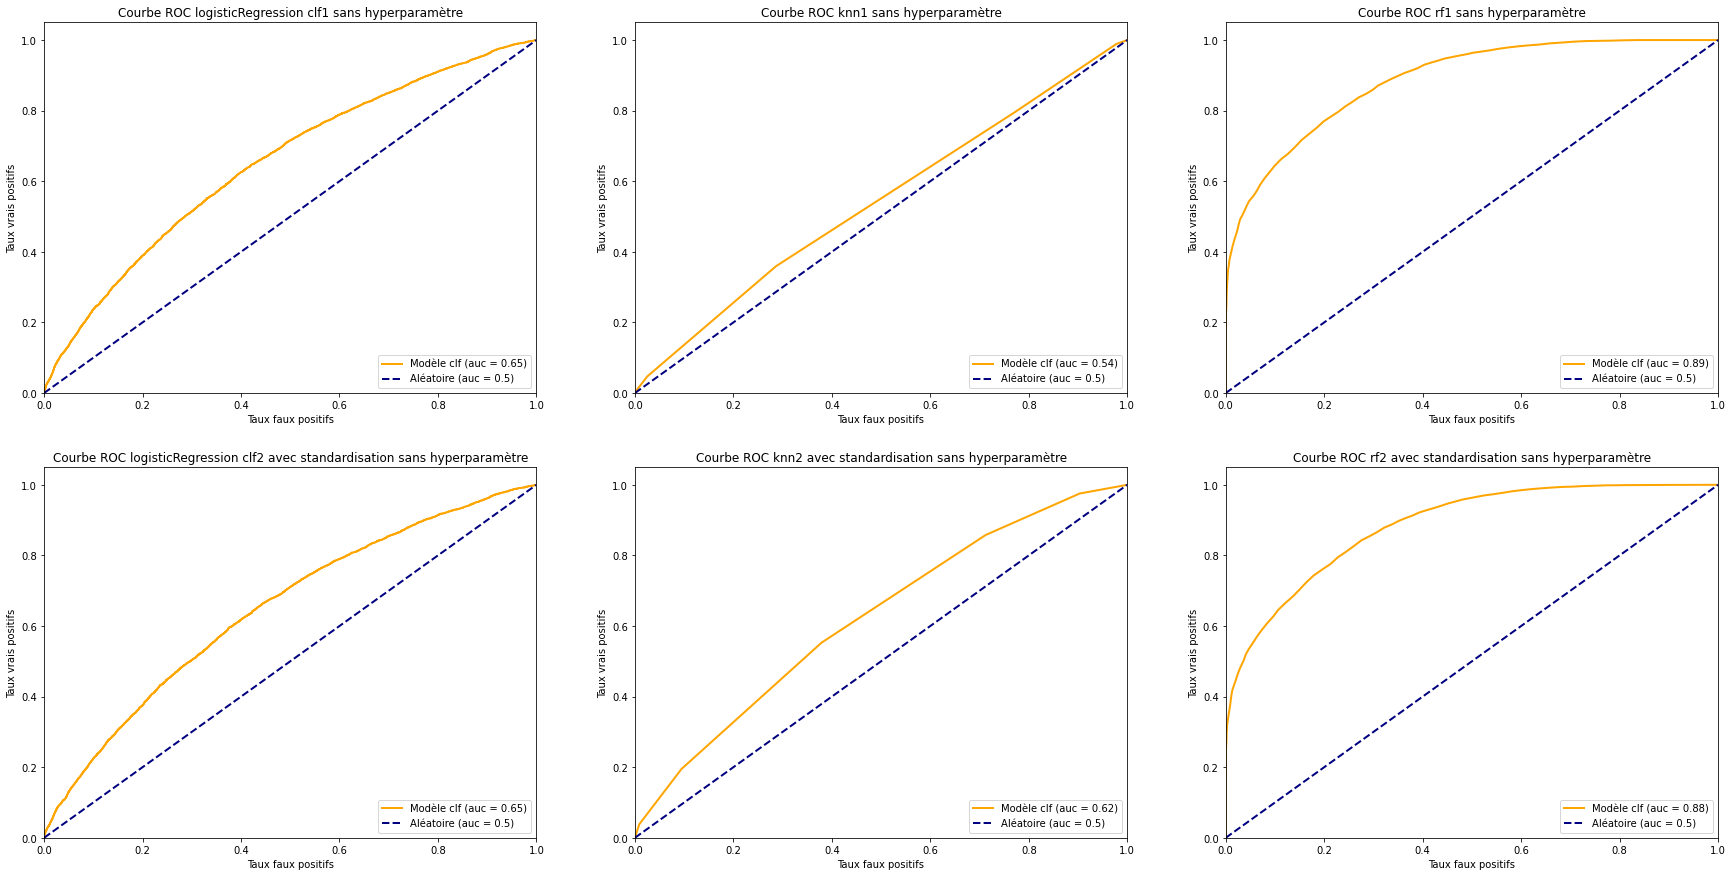

In [ ]:
#courbe ROC pour chaque modélisation sans hyperparamètre

plt.figure(figsize=(30,15))
plt.subplot(231)
plt.plot(fpr_clf1, tpr_clf1, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc_clf1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC logisticRegression clf1 sans hyperparamètre')
plt.legend(loc="lower right")


plt.subplot(232)
plt.plot(fpr_knn1, tpr_knn1, color='orange', lw=2, label='Modèle knn (auc = %0.2f)' % roc_auc_knn1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC knn1 sans hyperparamètre')
plt.legend(loc="lower right")


plt.subplot(233)
plt.plot(fpr_rf1, tpr_rf1, color='orange', lw=2, label='Modèle rf (auc = %0.2f)' % roc_auc_rf1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC rf1 sans hyperparamètre')
plt.legend(loc="lower right")


#courbe ROC pour chaque modélisation avec hyperparamètre


plt.subplot(234)
plt.plot(fpr_clf2, tpr_clf2, color='orange', lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc_clf2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC logisticRegression clf2 avec standardisation sans hyperparamètre')
plt.legend(loc="lower right")


plt.subplot(235)
plt.plot(fpr_knn2, tpr_knn2, color='orange', lw=2, label='Modèle knn (auc = %0.2f)' % roc_auc_knn2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC knn2 avec standardisation sans hyperparamètre')
plt.legend(loc="lower right")


plt.subplot(236)
plt.plot(fpr_rf2, tpr_rf2, color='orange', lw=2, label='Modèle RF (auc = %0.2f)' % roc_auc_rf2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC rf2 avec standardisation sans hyperparamètre')
plt.legend(loc="lower right")

plt.show();

conclusion de la modélisation sans hyperparamètre:

nous constatons que la standardisation MinMax n'améliore pas les performances du modèle LogisticRegression à l'inverse de celui des KNN.
Le modèle le plus performant dans les 2 cas est celui de RandomForest.
Nous choisissons doc de continuer avec ce modèle pour tenter d'améliorer ses performances.

2.3 Classification avec hyperparamètres
dans cette partie nous avons choisi de travailler sur 2 classifieurs pour et optimiser les hyperparamètres:


1.   RandomForest
2.   GradientBoosting



In [ ]:
#utilisation de la methode GridSearchCV pour rechercher le meilleur réglage de paramètre pour chacun des classifieurs
#définition du dictionnaire de paramètre

param_grid_rf=[{'n_estimators': [ 50, 100, 250,500],
'min_samples_leaf': [1, 3, 5], 'criterion':['gini', 'entropy', 'log_loss'],
'max_features': ['sqrt', 'log2', None]}]

param_grid_GB={'learning_rate': [0.1,1.0,10,100],
               'n_estimators': [ 50, 100, 250,500], 'loss': ['log_loss', 'deviance', 'exponential'],
               'subsample': [0.0, 0.5, 1.0], 'criterion':['friedman_mse', 'squared_error', 'mse'],
               'min_samples_leaf': [1, 3, 5], 'max_features': ['sqrt', 'log2', None]}

In [ ]:
#instanciation des classifieurs
RF3 = RandomForestClassifier()
GB3=GradientBoostingClassifier()

In [ ]:
# instanciation d'un gridSearchCV avec RF3 et GB3
gridcv=GridSearchCV(estimator=RF3, param_grid=param_grid_rf)
gridGB=GridSearchCV(estimator=GB3, param_grid=param_grid_GB)


In [ ]:
#entrainement du GridSearchCV
#gridcv.fit(X_train, y_train)
#gridGB.fit(X_train, y_train)

#48H d'execution pour RF3
#100H d'execution pour GB3


#affichage des meilleurs paramètres
gridcv.best_params_
gridGB.best_params_

l'entrainement de gridcv et gridBG a mené à l'établissement des meilleurs paramètres suivants:


1.   gridcv pour RandomForest:

**{'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 250}**


2.   gridGB pour GradientBoosting:

**{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 500, 'subsample': 0.5}**



In [ ]:
#entrainement des données avec les paramètres optimaux pour chaque classifieur

RF4=RandomForestClassifier(criterion='entropy', max_features=None, min_samples_leaf=3, n_estimators=250)
GB4= GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss= 'deviance', max_features= None, min_samples_leaf= 3, n_estimators= 500, subsample= 0.5)

RF4.fit(X_train, y_train)
GB4.fit(X_train, y_train)

#affichage des matrices de confusion
y_pred4_RF4= RF4.predict(X_test)
cm4_RF4=pd.crosstab(y_test, y_pred4_RF4,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model RandomForest:',RF4.score(X_test, y_test))
display('Matrice de confusion modele RandomForest:', cm4_RF4)


y_pred4_GB4= GB4.predict(X_test)
cm4_GB4=pd.crosstab(y_test, y_pred4_GB4,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model GradientBoosting:',GB4.score(X_test, y_test))
display('Matrice de confusion modele GradientBoosting:', cm4_GB4)

'le score du model RandomForest:'

0.7866808320286289

'Matrice de confusion modele RandomForest:'

classe predite,0,1
classe reelle,,
0,0.415511,0.084489
1,0.128830,0.371170


'le score du model GradientBoosting:'

0.7885260568105569

'Matrice de confusion modele GradientBoosting:'

classe predite,0,1
classe reelle,,
0,0.419593,0.080407
1,0.131067,0.368933


Evaluation des 2 modèles avec fixation des hyperparamètres

In [ ]:
print('le rapport de classification pour RandomForest paramètres optimisés est:', '\n',classification_report(y_test, y_pred4_RF4))
print('le rapport de classification pour GradientBoosting paramètres optimisés est:', '\n',classification_report(y_test, y_pred4_GB4))


le rapport de classification pour RandomForest paramètres optimisés est: 
               precision    recall  f1-score   support

           0       0.76      0.83      0.80      8942
           1       0.81      0.74      0.78      8942

    accuracy                           0.79     17884
   macro avg       0.79      0.79      0.79     17884
weighted avg       0.79      0.79      0.79     17884

le rapport de classification pour GradientBoosting paramètres optimisés est: 
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      8942
           1       0.82      0.74      0.78      8942

    accuracy                           0.79     17884
   macro avg       0.79      0.79      0.79     17884
weighted avg       0.79      0.79      0.79     17884



In [ ]:
#Calcul des probas pour chaque modèle afin de réaliser les courbes ROC
probs_rf4 = RF4.predict_proba(X_test)
fpr_rf4, tpr_rf4, seuils_rf4 = roc_curve(y_test, probs_rf4[:,1], pos_label =1)
roc_auc_rf4 = auc(fpr_rf4, tpr_rf4)


probs_GB4 = GB4.predict_proba(X_test)
fpr_GB4, tpr_GB4, seuils_GB4 = roc_curve(y_test, probs_GB4[:,1], pos_label =1)
roc_auc_GB4 = auc(fpr_GB4, tpr_GB4)




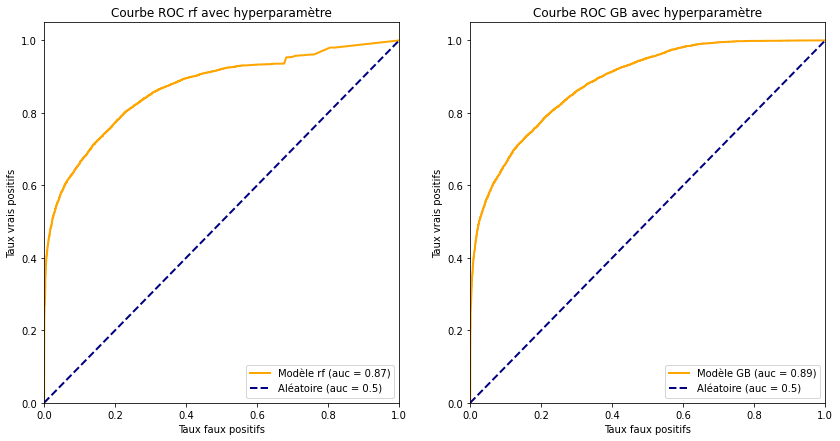

In [ ]:
#courbe ROC pour chaque modélisation sans hyperparamètre

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(fpr_rf4, tpr_rf4, color='orange', lw=2, label='Modèle rf (auc = %0.2f)' % roc_auc_rf4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC rf avec hyperparamètre')
plt.legend(loc="lower right")


plt.subplot(122)
plt.plot(fpr_GB4, tpr_GB4, color='orange', lw=2, label='Modèle GB (auc = %0.2f)' % roc_auc_GB4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC GB avec hyperparamètre')
plt.legend(loc="lower right");

### Conclusion:

les 2 modèles avec paramètres optimisés (RandomForest et GradientBoosting) ont des performances similaires

**Modélisation sur la moyenne mobile**

In [ ]:
target_mb = df_atp_moyenne_mobile['Player_cible']
data_mb= df_atp_moyenne_mobile.drop(['Player_cible','Date'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(data_mb, target_mb , test_size = 0.2, random_state = 66, shuffle = False)


#from sklearn import preprocessing
#from sklearn import utils
#lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(y_train)


LR_mb= linear_model.LogisticRegression()
RF_mb= RandomForestClassifier()

LR_mb.fit(X_train, y_train)
RF_mb.fit(X_train, y_train)


In [ ]:
y_pred_LR_mb = LR_mb.predict(X_test)
y_pred_RF_mb = RF_mb.predict(X_test)

cm_LR_mb = pd.crosstab(y_test, y_pred_LR_mb, rownames=['Classe réelle'], colnames=['Classe prédiction'], normalize= True)
cm_RF_mb = pd.crosstab(y_test, y_pred_RF_mb, rownames=['Classe réelle'], colnames=['Classe prédiction'], normalize = True)
display('Matrice de confusion modele LogisticRegression:', cm_LR_mb)
display('Matrice de confusion modele Random Forest:', cm_RF_mb)

'Matrice de confusion modele LogisticRegression:'

Classe prédiction,0.0,1.0
Classe réelle,,
0.0,0.316837,0.183191
1.0,0.264161,0.235811


'Matrice de confusion modele Random Forest:'

Classe prédiction,0.0,1.0
Classe réelle,,
0.0,0.351619,0.148409
1.0,0.292177,0.207795


In [ ]:
print("LR:",LR_mb.score(X_test, y_test))
print("RF:",RF_mb.score(X_test, y_test))


LR: 0.5526477660347816
RF: 0.5594139685735056


In [ ]:
clf = GradientBoostingClassifier(criterion= 'friedman_mse',
 learning_rate= 0.1,
 loss= 'deviance',
 max_features= None,
 min_samples_leaf= 3,
 n_estimators= 500,
 subsample= 0.5).fit(X_train, y_train)


clf_gb = GradientBoostingClassifier().fit(X_train, y_train)


In [ ]:
print("Gradient Boosting avec hyperparamètre",clf.score(X_test,y_test))
print("Gradient Boosting sans hyperparamètre",clf_gb.score(X_test,y_test))

Gradient Boosting avec hyperparamètre 0.5723312643292513
Gradient Boosting sans hyperparamètre 0.5690879606330034


In [ ]:
y_pred_gb = clf.predict(X_test)
print(classification_report(y_test,y_pred_gb))

y_pred_gb_ = clf_gb.predict(X_test)
print(classification_report(y_test,y_pred_gb_))

              precision    recall  f1-score   support

         0.0       0.56      0.72      0.63      8942
         1.0       0.60      0.43      0.50      8941

    accuracy                           0.57     17883
   macro avg       0.58      0.57      0.56     17883
weighted avg       0.58      0.57      0.56     17883

              precision    recall  f1-score   support

         0.0       0.55      0.72      0.63      8942
         1.0       0.60      0.42      0.49      8941

    accuracy                           0.57     17883
   macro avg       0.58      0.57      0.56     17883
weighted avg       0.58      0.57      0.56     17883



In [ ]:
from sklearn.ensemble import AdaBoostClassifier 
ac = AdaBoostClassifier ()
ac.fit(X_train, y_train)
ac.score(X_test, y_test)

0.5593580495442599

**Interprétabilité**


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display
target = df_atp_final['Player_cible']
data = df_atp_final.drop('Player_cible', axis=1) 

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66, shuffle=False)
rf1.fit(X_train, y_train)

print("Validation Mean F1 Score: ", cross_val_score(
    rf1, X_train, y_train, cv=5, scoring='f1_macro').mean())

print("Validation Mean Accuracy: ", cross_val_score(
    rf1, X_train, y_train, cv=5, scoring='accuracy').mean())

y_pred_clf = rf1.predict(X_test)
print(classification_report(y_test, y_pred_clf))

print("score:", accuracy_score(y_test, y_pred_clf))

Validation Mean F1 Score:  0.7585565789175334
Validation Mean Accuracy:  0.7605696921624526
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      8942
           1       0.81      0.67      0.74      8942

    accuracy                           0.76     17884
   macro avg       0.77      0.76      0.76     17884
weighted avg       0.77      0.76      0.76     17884

score: 0.7580518899575039


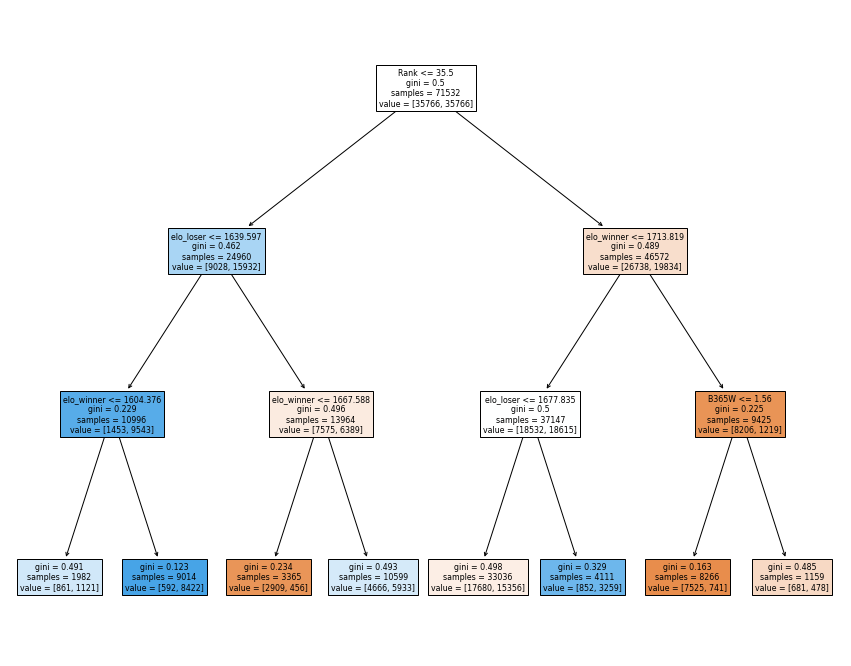

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train, y_train)
from sklearn.tree import plot_tree
plt.figure(figsize=(15,12))
plot_tree(tree_clf, feature_names = X_train.columns.tolist(), filled=True); 

In [ ]:
feat_importances = pd.Series(
    tree_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh');

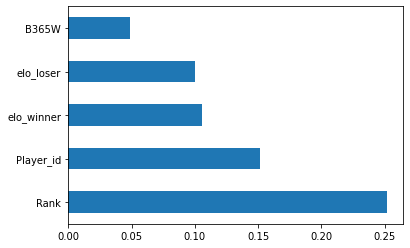

In [ ]:
feat_importances = pd.Series(
    rf1.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh');

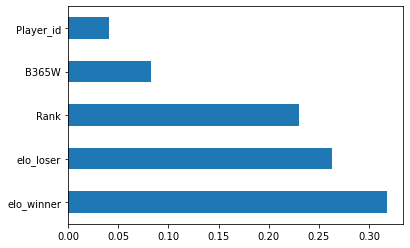

In [ ]:
feat_importances = pd.Series(
    GB4.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh');

In [ ]:
pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.8 MB/s 


Les TreeExplainer permettent d'interpréter les différents modèles d'ensemble à base d'arbres, de manière rapide grâce à l'implémentation d'un algorithme spécifique. En revanche pour l'interprétation de modèles complexes différents ('GradientExplainer', 'DeepExplainer', 'KernelExplainer'), le calcul reste assez lent.

In [ ]:
import shap 
explainer = shap.TreeExplainer(rf1)

In [ ]:
print('Expected Value:', explainer.expected_value)

Expected Value: [0.50000461 0.49999539]


In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
pd.DataFrame(shap_values).head()

NameError: ignored

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## **Etape 3: Web Scraping (code disponible en notebook)**

## 1.   Installation de selenium

Site de référence : "https://www.ultimatetennisstatistics.com/"

/!\ Attention,  il sera important de noter que toutes les étapes jusqu’à la modélisation se feront à l’aide de Jupyter Notebook et non avec Google Colab. Ceci est dû au fait que Google Colab ne fonctionne pas en local et ne permet pas d’ouvrir un driver indépendant, ce qui rend notre web scraping alors inefficace et qui ne nous rendra pas la totalité des informations(pas de changement de page possible, pas de clic possible sur un joueur …).

In [ ]:
pip install selenium

In [ ]:
#importation des librairies 
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd 
import numpy as np
from time import sleep
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.support.ui import Select

2.  Extraction des variables tennistiques d'un joueur de tennis

In [ ]:
path = "C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get("https://www.ultimatetennisstatistics.com/playerProfile?playerId=4544&tab=statistics")
driver.maximize_window()

tds = driver.find_elements(By.TAG_NAME, "td")
tds_pct=[]
for td in tds:
        tds_pct.append(str(td.text))
        
df_td2 = pd.DataFrame(tds_pct, columns = ['variables'])
df_td2['index'] = df_td2.index
print(df_td2.head(40))
driver.close()

3. Extraction et création d'un dataframe comportant tous les joueurs dont on aura les infos pour l'année 2016

In [ ]:
path = "C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get("https://www.ultimatetennisstatistics.com/statsLeaders")
driver.maximize_window()
driver.find_element(By.ID,"season").click()
driver.find_element(By.XPATH, "//*[@id='season']/option[9]").click()
driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/button").click()
driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/ul/li[4]/a").click() # Pour faire apparaitre tous les joueurs à l'écran
 

sleep(5)
total_rows = len(driver.find_elements(By.XPATH, "//*[@id='statsLeadersTable']/tbody/tr"))
print("nombre de joueurs " + repr(total_rows))

player_names = driver.find_elements(By.XPATH, "//*[@id='statsLeadersTable']/tbody/tr/td[3]")


In [ ]:
players_names=[]
for a in player_names:
        players_names.append(str(a.text))
players_names

In [ ]:
df_noms = pd.DataFrame(players_names, columns = ['Noms'])
for ind in df_noms.index: #début de la boucle
    print(df_noms['Noms'][ind])
    
df_noms['index'] = df_noms.index
df_noms

4. Extraction des statistiques de tous les joueurs de l'année 2016 

In [ ]:
path = "C:\Program Files (x86)\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get('https://www.ultimatetennisstatistics.com/statsLeaders')
driver.maximize_window()
df_ind = pd.DataFrame() # df vide

for ind in df_noms.index: #début de la boucle 
    print(df_noms['Noms'][ind])
    driver.find_element(By.ID,"season").click() ## étape 1 : sélection du joueur
    driver.find_element(By.XPATH, "//*[@id='season']/option[9]").click() # Pour être dans l'année 2016
    driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/button").click()
    driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/ul/li[4]/a").click() # Pour faire apparaitre tous les joueurs à l'écran
    sleep(5)
    driver.find_element(By.LINK_TEXT,df_noms['Noms'][ind]).click() # cliquer sur le nom du joueur, nom du joueur doit changer apres WS
    ### pub

    sleep(10) # nouvelle page ouverte, laisser du temps mort
    driver.find_element(By.XPATH,"//*[@id='playerPills']/li[9]/a").click()
    sleep(3) # nouveau menu, temps mort nécessaire
    driver.find_element(By.ID,"statisticsPill").click()
    sleep(3) # nouveau menu, temps mort nécessaire
    Select(driver.find_element(By.XPATH,"//*[@id='statsSeason']")).select_by_visible_text("2016")
    sleep(3) 
    ths_player = driver.find_elements(By.TAG_NAME, "th")
    ths_pct_player=[]
    
    for th in ths_player:
        ths_pct_player.append(str(th.text))
          
        # étape 4: création du/des df        
        
        df_ind_tmp = pd.DataFrame(ths_pct_player, columns = [df_noms['Noms'][ind]]) # nom qui change ex isner, federer...
        df_ind_tmp = df_ind_tmp.replace({'': np.nan})
        df_ind_tmp = df_ind_tmp.dropna() ## enlever / ne pas utiliser
        df_ind_tmp = df_ind_tmp.reset_index()
        df_ind_tmp = df_ind_tmp.drop('index',axis=1)
        df_ind_tmp['index'] = df_ind_tmp.index


    df_ind = pd.concat([df_ind,df_ind_tmp],axis=1)
    df_ind=df_ind.replace({'': np.nan})
    df_ind =df_ind.dropna() ## enlever / ne pas utiliser         
    print(df_ind.head(30)) # ! renommer les df car un df = 1 joueur
    
    
    sleep(3)
    driver.find_element(By.XPATH,"//*[@id='menuNavbar']/ul/li[7]/a").click()
    sleep(3)
    driver.find_element(By.XPATH,"//*[@id='menuNavbar']/ul/li[7]/ul/li[1]/a").click()
    sleep(10)
    driver.find_element(By.ID,"season").click()
    driver.find_element(By.XPATH, "//*[@id='season']/option[9]").click()
    driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/button").click()
    driver.find_element(By.XPATH, "//*[@id='statsLeadersTable-header']/div/div/div[4]/div[1]/ul/li[4]/a").click() # Pour faire apparaitre tous les joueurs à l'écran
    sleep(5)
    
print("end !")
driver.close()
df_ind = df_ind.reset_index()
df_ind = df_ind.drop('index',axis=1)
df_ind['index'] = df_ind.index
print(df_ind.head(30)) # ! renommer les df car un df = 1 joueur


5. Fusion des dataframes créés 

In [ ]:
df_ind = df_ind.drop(index=[0,9,17],axis=0)
df_ind = df_ind.drop('level_0', axis= 1) 
df_ind = df_ind.reset_index()
df_ind = df_ind.drop('index', axis=1)
df_ind.head(30)

In [ ]:
df_td2 = df_td2.drop('index', axis = 1)

In [ ]:
df2016 = df_ind.join(df_td2, how='outer')
df2016= df2016.set_index('variables')
df2016= df2016.dropna()
df2016 = df2016.transpose()
df2016.head(30)

# Modélisation avec statistiques scrapées

Evaluation du modéle avec et sans stats joueurs: les stats sont scrapées pour l'année 2016 _ nous allons donc utiliser ces stats pour appliquer la prédiction sur l'année 2017

Pour utiliser les stats scrapées nous devons faire une jointure entre les noms de joueurs de df_stats2016 et le df_joueur créé pour la modélisation.

travail sur le df_joueur: scinder la colonne Player en Name et 1stName qui permettra de faire la clé de jointure avec le df_stats2016

In [ ]:
df_joueur

,Player,Player_id
0,Dosedel S.,1000
1,Kiefer N.,1001
2,Gaudio G.,1002
3,El Aynaoui Y.,1003
4,Cherkasov A.,1004
...,...,...
1397,Andreev A.,2397
1398,Korda S.,2398
1399,Auger-Aliassime F.,2399
1400,Gaston H.,2400


In [ ]:
#première étape, remplacement de quelques noms de la colonne 'Player' permettant d'apliquer le regex du text Mining:
df_joueur['Player']=df_joueur['Player'].replace(to_replace='Van D. Merwe I.', value='Van D Merwe I.')
df_joueur['Player']=df_joueur['Player'].replace(to_replace='Zhang Ze', value='Zhang Ze.')

#text Mining
#creation d'une liste des noms de joueurs à partir de la colonne 'Player'

nom_joueur = ""
for comment in df_joueur.Player : 
    nom_joueur += comment

#définition du regex qui va permettre de supprimer l'initiale du prénom de chaque joueur suivie du "."
r=re.compile(r"([A-Z]*[a-z]*'?\s?-?[A-Z]{0,1}[a-z]*\s?-?[A-Z]{0,1}[a-z]*\s?-?[A-Z]{0,1}[a-z]+)")
nom_joueur=r.findall(nom_joueur)


#creation d'une serie "nom_joueur_serie" à partir de l'étape de text mining qui va permettre de l'intégrer au dataframe df_joueur
nom_joueur_serie=pd.Series(nom_joueur)
df_joueur['Name']=nom_joueur_serie

In [ ]:
#vérification la longueur de nom_joueur est égale à la longeur de df_joueur: l'étape de text mining semble réussie
display(len(nom_joueur))

#quelques ajustements après vérif avec le .head
df_joueur['Name']=df_joueur['Name'].replace(to_replace='HZhang Zh', value='Zhang Zh')
df_joueur.loc[1133]=df_joueur.loc[1133].replace(to_replace='Siriluethaiwattana', value='Raja')

display(df_joueur.head())

1402

,Player,Player_id,Name
0,Dosedel S.,1000,Dosedel
1,Kiefer N.,1001,Kiefer
2,Gaudio G.,1002,Gaudio
3,El Aynaoui Y.,1003,El Aynaoui
4,Cherkasov A.,1004,Cherkasov


In [ ]:
df_joueur[df_joueur['Name']=='Del Potro']

,Player,Player_id,Name
463,Del Potro J.M.,1463,Del Potro
562,Del Potro J.,1562,Del Potro
872,Del Potro J. M.,1872,Del Potro


seconde étape: travail sur le fichier df_stats2016:

 

*   importation du fichier cvs de webscraping du site ultimatetennis permettant d'obtenir les stats de l'année 2016 des joueurs
*   travail sur les noms des joueurs pour former la clé de jointure avec df_joueur





In [ ]:
from google.colab import files
files.upload()

Saving df_stats2016.csv to df_stats2016.csv


{'df_stats2016.csv': b',Ace %,Double Fault %,1st Serve %,1st Serve Won %,2nd Serve Won %,Break Points Saved %,Service Points Won %,Service Games Won %,Ace Against %,Double Fault Against %,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Points Dominance,Games Dominance,Break Points Ratio,Total Points Won %,Games Won %,Sets Won %,Matches Won %,Match Time\r\nJohn Isner,25.6%,2.9%,69.4%,82.0%,55.1%,71.7%,73.8%,93.4%,9.5%,3.8%,22.6%,42.4%,32.7%,30.2%,10.9%,1.15,1.65,1.16,51.6%,52.5%,59.5%,61.1%,2:00\r\nIvo Karlovic,24.2%,6.2%,64.2%,81.9%,55.2%,71.5%,72.3%,92.2%,9.0%,3.7%,19.4%,39.2%,29.4%,26.6%,7.1%,0.96,0.90,1.03,49.8%,49.6%,53.8%,57.1%,1:49\r\nGilles Muller,19.1%,4.6%,60.5%,81.4%,52.6%,65.4%,70.0%,87.9%,9.0%,3.7%,25.2%,44.0%,33.2%,32.1%,14.1%,1.07,1.17,0.96,50.9%,51.4%,55.6%,59.3%,2:02\r\nMilos Raonic,16.0%,4.2%,64.1%,80.0%,55.3%,69.4%,71.1%,90.6%,6.0%,3.4%,28.2%,49.1%,35.5%,36.1%,18.3%,1.25,1.94,1.16,53.0%,54.9%,69.6%,75.4%,1:49\r\nMa

In [ ]:
df_stats2016=pd.read_csv('df_stats2016.csv')

In [ ]:
df_stats2016.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              176 non-null    object 
 1   Ace %                   176 non-null    object 
 2   Double Fault %          176 non-null    object 
 3   1st Serve %             176 non-null    object 
 4   1st Serve Won %         176 non-null    object 
 5   2nd Serve Won %         176 non-null    object 
 6   Break Points Saved %    176 non-null    object 
 7   Service Points Won %    176 non-null    object 
 8   Service Games Won %     176 non-null    object 
 9   Ace Against %           176 non-null    object 
 10  Double Fault Against %  176 non-null    object 
 11  1st Srv. Return Won %   176 non-null    object 
 12  2nd Srv. Return Won %   176 non-null    object 
 13  Break Points Won %      176 non-null    object 
 14  Return Points Won %     176 non-null    ob

In [ ]:

df_stats2016=df_stats2016.rename(columns={'Unnamed: 0':'Player'})

#creation d'un df ne contenant que les colonnes de type objet pour supprimer les % et transformer en float
df_stats2016obj=df_stats2016.select_dtypes(include='object')

#creation d'une fonction permettant de supprimer les % dans les colonne object
def retrait(df):
  for column in df:
    df[column]=df[column].str[:-1]

#application de la fonction au df_stats2016obj:
retrait(df_stats2016obj)   

#vérification de la transformation:
df_stats2016obj.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Player,Ace %,Double Fault %,1st Serve %,1st Serve Won %,2nd Serve Won %,Break Points Saved %,Service Points Won %,Service Games Won %,Ace Against %,...,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %,Match Time
0,John Isne,25.6,2.9,69.4,82.0,55.1,71.7,73.8,93.4,9.5,...,22.6,42.4,32.7,30.2,10.9,51.6,52.5,59.5,61.1,2:0
1,Ivo Karlovi,24.2,6.2,64.2,81.9,55.2,71.5,72.3,92.2,9.0,...,19.4,39.2,29.4,26.6,7.1,49.8,49.6,53.8,57.1,1:4
2,Gilles Mulle,19.1,4.6,60.5,81.4,52.6,65.4,70.0,87.9,9.0,...,25.2,44.0,33.2,32.1,14.1,50.9,51.4,55.6,59.3,2:0
3,Milos Raoni,16.0,4.2,64.1,80.0,55.3,69.4,71.1,90.6,6.0,...,28.2,49.1,35.5,36.1,18.3,53.0,54.9,69.6,75.4,1:4
4,Marin Cili,13.6,3.1,55.4,79.3,53.8,62.6,67.9,86.0,8.1,...,28.7,49.9,39.2,37.0,22.6,52.0,54.5,63.4,67.1,1:5


In [ ]:
#réorganisation du df_stats2016obj et df_stats2016
#suppression des colonnes player  et match time (car dernier caractère supprimé)
df_stats2016obj=df_stats2016obj.drop(columns=['Player','Match Time'])


#transformation des colonnes de df_stats2016obj en float
df_stats2016obj=df_stats2016obj[['Ace %', 'Double Fault %', '1st Serve %', '1st Serve Won %',
       '2nd Serve Won %', 'Break Points Saved %', 'Service Points Won %',
       'Service Games Won %', 'Ace Against %', 'Double Fault Against %',
       '1st Srv. Return Won %', '2nd Srv. Return Won %', 'Break Points Won %',
       'Return Points Won %', 'Return Games Won %', 'Total Points Won %',
       'Games Won %', 'Sets Won %', 'Matches Won %']].astype('float64')

#suppression des colonnes avec pourcentage dans le df_stats2016
df_stats2016=df_stats2016.drop(columns=['Ace %', 'Double Fault %', '1st Serve %', '1st Serve Won %',
       '2nd Serve Won %', 'Break Points Saved %', 'Service Points Won %',
       'Service Games Won %', 'Ace Against %', 'Double Fault Against %',
       '1st Srv. Return Won %', '2nd Srv. Return Won %', 'Break Points Won %',
       'Return Points Won %', 'Return Games Won %', 'Total Points Won %',
       'Games Won %', 'Sets Won %', 'Matches Won %'])

#concatenation  vec df_stats2016 obj à partir des index
df_stats2016_final=pd.concat([df_stats2016, df_stats2016obj], axis =1)

display(df_stats2016_final)

,Player,Points Dominance,Games Dominance,Break Points Ratio,Match Time,Ace %,Double Fault %,1st Serve %,1st Serve Won %,2nd Serve Won %,...,Double Fault Against %,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %
0,John Isner,1.15,1.65,1.16,2:00,25.6,2.9,69.4,82.0,55.1,...,3.8,22.6,42.4,32.7,30.2,10.9,51.6,52.5,59.5,61.1
1,Ivo Karlovic,0.96,0.90,1.03,1:49,24.2,6.2,64.2,81.9,55.2,...,3.7,19.4,39.2,29.4,26.6,7.1,49.8,49.6,53.8,57.1
2,Gilles Muller,1.07,1.17,0.96,2:02,19.1,4.6,60.5,81.4,52.6,...,3.7,25.2,44.0,33.2,32.1,14.1,50.9,51.4,55.6,59.3
3,Milos Raonic,1.25,1.94,1.16,1:49,16.0,4.2,64.1,80.0,55.3,...,3.4,28.2,49.1,35.5,36.1,18.3,53.0,54.9,69.6,75.4
4,Marin Cilic,1.15,1.61,1.05,1:54,13.6,3.1,55.4,79.3,53.8,...,3.6,28.7,49.9,39.2,37.0,22.6,52.0,54.5,63.4,67.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Marton Fucsovics,0.97,0.94,1.14,2:17,4.3,3.7,55.7,59.6,51.3,...,2.9,35.4,52.3,48.1,42.9,33.8,49.6,48.7,43.8,40.0
172,Carlos Berlocq,0.91,0.87,1.30,1:43,2.7,3.1,72.1,60.2,45.1,...,4.3,32.2,50.2,54.8,39.8,32.1,48.6,48.1,39.1,40.0
173,Pablo Andujar,0.88,0.57,0.91,1:46,2.5,3.2,66.3,65.6,43.9,...,4.3,23.5,54.5,43.9,36.5,18.9,47.6,42.6,25.0,12.5
174,Noah Rubin,0.84,0.47,0.83,1:49,2.6,4.2,61.3,67.0,53.3,...,6.0,19.0,48.7,31.0,32.2,11.0,47.3,44.5,37.5,33.3


In [ ]:
#affichage de la colonne de df_stats2016_final (Player) 
df_stats2016_final['Player']

0            John Isner
1          Ivo Karlovic
2         Gilles Muller
3          Milos Raonic
4           Marin Cilic
             ...       
171    Marton Fucsovics
172      Carlos Berlocq
173       Pablo Andujar
174          Noah Rubin
175        Tobias Kamke
Name: Player, Length: 176, dtype: object

In [ ]:
#creation d'une fonction permettant de séparer les noms et prénoms des joueurs de la colonne player

def split_p(prenom):
  sep =prenom.split(" ")
  prenom = sep[0]
  return prenom

def split_n(nom):
  sep =nom.split(" ")
  nom = sep[1]
  return nom

Prenom  = df_stats2016_final['Player'].apply(split_p)
Nom  = df_stats2016_final['Player'].apply(split_n)
df_stats2016_final['1stName'] = Prenom
df_stats2016_final['Name']= Nom


#ajustement de certaines lignes après vérification du df_stats2016_final . head()

df_stats2016_final['Name']=df_stats2016_final['Name'].replace(to_replace='Wilfried', value='Tsonga')
df_stats2016_final['1stName']=df_stats2016_final['1stName'].replace(to_replace='Jo', value='Jo Wilfried')
df_stats2016_final.loc[28]=df_stats2016_final.loc[28].replace(to_replace='Martin', value='Del Potro')
df_stats2016_final.loc[28]=df_stats2016_final.loc[28].replace(to_replace='Juan', value='Juan Martin')
df_stats2016_final.loc[29]=df_stats2016_final.loc[29].replace(to_replace='Taylor', value='Taylor Harry')
df_stats2016_final.loc[29]=df_stats2016_final.loc[29].replace(to_replace='Harry', value='Fritz')
df_stats2016_final.loc[32]=df_stats2016_final.loc[32].replace(to_replace='Carreno', value='Carreno Busta')
df_stats2016_final.loc[53]=df_stats2016_final.loc[53].replace(to_replace='Lennard', value='Struff')
df_stats2016_final.loc[57]=df_stats2016_final.loc[57].replace(to_replace='Garcia', value='Garcia-Lopez')
df_stats2016_final.loc[62]=df_stats2016_final.loc[62].replace(to_replace='Hugues', value='Herbert')
df_stats2016_final.loc[75]=df_stats2016_final.loc[75].replace(to_replace='Henri', value='Mathieu')
df_stats2016_final.loc[86]=df_stats2016_final.loc[86].replace(to_replace='De', value='De Bakker')
df_stats2016_final.loc[102]=df_stats2016_final.loc[102].replace(to_replace='Hsun', value='Lu')
df_stats2016_final.loc[113]=df_stats2016_final.loc[113].replace(to_replace='Sebastian', value='Schwartzman')
df_stats2016_final.loc[124]=df_stats2016_final.loc[124].replace(to_replace='Carballes', value='Carballes Baena')
df_stats2016_final.loc[128]=df_stats2016_final.loc[128].replace(to_replace='Munoz', value='Munoz de la Nava')
df_stats2016_final.loc[140]=df_stats2016_final.loc[140].replace(to_replace='Dutra', value='Dutra Silva')
df_stats2016_final.loc[154]=df_stats2016_final.loc[154].replace(to_replace='De', value='De Schepper')

df_stats2016_final.head(180)

,Player,Points Dominance,Games Dominance,Break Points Ratio,Match Time,Ace %,Double Fault %,1st Serve %,1st Serve Won %,2nd Serve Won %,...,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %,1stName,Name
0,John Isner,1.15,1.65,1.16,2:00,25.6,2.9,69.4,82.0,55.1,...,42.4,32.7,30.2,10.9,51.6,52.5,59.5,61.1,John,Isner
1,Ivo Karlovic,0.96,0.90,1.03,1:49,24.2,6.2,64.2,81.9,55.2,...,39.2,29.4,26.6,7.1,49.8,49.6,53.8,57.1,Ivo,Karlovic
2,Gilles Muller,1.07,1.17,0.96,2:02,19.1,4.6,60.5,81.4,52.6,...,44.0,33.2,32.1,14.1,50.9,51.4,55.6,59.3,Gilles,Muller
3,Milos Raonic,1.25,1.94,1.16,1:49,16.0,4.2,64.1,80.0,55.3,...,49.1,35.5,36.1,18.3,53.0,54.9,69.6,75.4,Milos,Raonic
4,Marin Cilic,1.15,1.61,1.05,1:54,13.6,3.1,55.4,79.3,53.8,...,49.9,39.2,37.0,22.6,52.0,54.5,63.4,67.1,Marin,Cilic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Marton Fucsovics,0.97,0.94,1.14,2:17,4.3,3.7,55.7,59.6,51.3,...,52.3,48.1,42.9,33.8,49.6,48.7,43.8,40.0,Marton,Fucsovics
172,Carlos Berlocq,0.91,0.87,1.30,1:43,2.7,3.1,72.1,60.2,45.1,...,50.2,54.8,39.8,32.1,48.6,48.1,39.1,40.0,Carlos,Berlocq
173,Pablo Andujar,0.88,0.57,0.91,1:46,2.5,3.2,66.3,65.6,43.9,...,54.5,43.9,36.5,18.9,47.6,42.6,25.0,12.5,Pablo,Andujar
174,Noah Rubin,0.84,0.47,0.83,1:49,2.6,4.2,61.3,67.0,53.3,...,48.7,31.0,32.2,11.0,47.3,44.5,37.5,33.3,Noah,Rubin


In [ ]:
#jointure entre df_joueur et df_stats2016_final grace à la clé 'Name' correspondant au nom de famille de chaque joueur
#les na au niveau des stats correspondent aux joueurs ne faisant pas partie de l'année 2016/2017
joueur_jointure=df_joueur.merge(df_stats2016_final, on='Name', how='left')

In [ ]:
joueur_jointure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1408 entries, 0 to 1407
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Player_x                1408 non-null   object 
 1   Player_id               1408 non-null   int64  
 2   Name                    1408 non-null   object 
 3   Player_y                223 non-null    object 
 4   Points Dominance        223 non-null    float64
 5   Games Dominance         223 non-null    float64
 6   Break Points Ratio      223 non-null    float64
 7   Match Time              223 non-null    object 
 8   Ace %                   223 non-null    float64
 9   Double Fault %          223 non-null    float64
 10  1st Serve %             223 non-null    float64
 11  1st Serve Won %         223 non-null    float64
 12  2nd Serve Won %         223 non-null    float64
 13  Break Points Saved %    223 non-null    float64
 14  Service Points Won %    223 non-null    

In [ ]:
#----------------------------------------
# sauvegarde nouveau dataframe joueur_jointure
#----------------------------------------
#filename='joueur_jointure.csv'
#df_atp_final.to_csv(filename, index=False)
#download = files.download(filename)
#print (filename, 'sauvegarde')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

joueur_jointure.csv sauvegarde


1.Modelisation sur 2016/2017 sans stats joueurs pour comparer l'ajout de ses stats à notre modélisation

In [ ]:
#creation du dataframe df_atp_1617 sans stats
df_atp_1617=df_atp_encodage[(df_atp_encodage['Annee']==2016) |(df_atp_encodage['Annee']==2017)]

#Trie par ordre croissant sur la Date
df_atp_1617 = df_atp_1617.sort_values(by ='Date' , ascending = True)
display(df_atp_1617)
#Suppression des variables
colonne_a_supp1617 = ['Date','Round','Surface','Comment','Court','Series','Player','Wsets','Lsets', 
                  'proba_elo','Best of', 'WRank','LRank', 'Winner','Loser', 'index','match_id']
df_atp_1617 = df_atp_encodage.drop(colonne_a_supp1617, axis = 1)
display(df_atp_1617)
#Normalisation de Tournois & Location
#df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Tournament'], prefix= 'tournois'))
#df_atp_final = df_atp_final.join(pd.get_dummies(df_atp_final['Location'], prefix= 'loc'))
#df_atp_final = df_atp_final.drop(['Tournament','Location'], axis = 1)

#df_atp_final.info()

df_atp_1617 = df_atp_1617.fillna(0)
display(df_atp_1617.isna().sum())

df_atp_1617.info()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,round,comment,court,series,index,match_id,Player,Player_id,Rank,Player_cible
77698,2,Chennai,Chennai Open,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Pavic A.,...,1,1,1,250,38849,48849,Almagro N.,1362,73,0
77684,3,Doha,Qatar Exxon Mobil Open,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,...,1,1,1,250,38842,48842,Chardy J.,1483,31,1
77689,3,Doha,Qatar Exxon Mobil Open,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Munoz-De La Nava D.,...,1,1,1,250,38844,48844,Munoz-De La Nava D.,1666,75,1
77687,3,Doha,Qatar Exxon Mobil Open,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Dzumhur D.,...,1,1,1,250,38843,48843,Cecchinato M.,1836,90,0
77686,3,Doha,Qatar Exxon Mobil Open,2016-01-04,ATP250,Outdoor,Hard,1st Round,3,Dzumhur D.,...,1,1,1,250,38843,48843,Dzumhur D.,1786,82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88195,67,London,Masters Cup,2017-11-19,Masters Cup,Indoor,Hard,The Final,3,Dimitrov G.,...,7,1,0,2000,44097,54097,Goffin D.,1685,8,0
88197,1,Brisbane,Brisbane International,2017-12-31,ATP250,Outdoor,Hard,1st Round,3,Dolgopolov O.,...,1,1,1,250,44098,54098,Schwartzman D.,1754,26,0
88198,1,Brisbane,Brisbane International,2017-12-31,ATP250,Outdoor,Hard,1st Round,3,De Minaur A.,...,1,1,1,250,44099,54099,Johnson S.,1734,44,0
88196,1,Brisbane,Brisbane International,2017-12-31,ATP250,Outdoor,Hard,1st Round,3,Dolgopolov O.,...,1,1,1,250,44098,54098,Dolgopolov O.,1615,169,1


,ATP,Location,Tournament,PSW,PSL,B365W,B365L,elo_winner,elo_loser,Annee,Mois,surface,round,comment,court,series,Player_id,Rank,Player_cible
0,1,Adelaide,Australian Hardcourt Championships,NaN,NaN,NaN,NaN,1500.000000,1500.000000,2000,1,3,1,1,1,3000,1000,63,1
119,1,Adelaide,Australian Hardcourt Championships,NaN,NaN,NaN,NaN,1484.000000,1500.000000,2000,1,3,1,1,1,3000,1903,351,0
120,2,Chennai,Gold Flake Open,NaN,NaN,NaN,NaN,1483.229860,1500.000000,2000,1,3,1,1,1,3000,1038,99,1
121,2,Chennai,Gold Flake Open,NaN,NaN,NaN,NaN,1483.229860,1500.000000,2000,1,3,1,1,1,3000,1161,113,0
122,1,Adelaide,Australian Hardcourt Championships,NaN,NaN,NaN,NaN,1516.000000,1500.000000,2000,1,3,1,1,1,3000,1027,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89406,17,Dubai,Dubai Tennis Championships,1.65,2.43,1.66,2.20,1835.901543,1842.459807,2018,3,3,7,1,1,500,1759,15,0
89413,16,Acapulco,Abierto Mexicano,1.52,2.75,1.50,2.62,1966.532849,1851.413609,2018,3,3,7,1,1,500,1557,8,0
89414,18,Sao Paulo,Brasil Open,1.38,3.38,1.36,3.25,1814.065865,1605.738153,2018,3,1,7,1,0,250,1493,20,1
89412,16,Acapulco,Abierto Mexicano,1.52,2.75,1.50,2.62,1966.532849,1851.413609,2018,3,3,7,1,1,500,1463,9,1


ATP             0
Location        0
Tournament      0
PSW             0
PSL             0
B365W           0
B365L           0
elo_winner      0
elo_loser       0
Annee           0
Mois            0
surface         0
round           0
comment         0
court           0
series          0
Player_id       0
Rank            0
Player_cible    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89416 entries, 0 to 89415
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ATP           89416 non-null  int64  
 1   Location      89416 non-null  object 
 2   Tournament    89416 non-null  object 
 3   PSW           89416 non-null  float64
 4   PSL           89416 non-null  float64
 5   B365W         89416 non-null  float64
 6   B365L         89416 non-null  float64
 7   elo_winner    89416 non-null  float64
 8   elo_loser     89416 non-null  float64
 9   Annee         89416 non-null  int64  
 10  Mois          89416 non-null  int64  
 11  surface       89416 non-null  int64  
 12  round         89416 non-null  int64  
 13  comment       89416 non-null  int64  
 14  court         89416 non-null  int64  
 15  series        89416 non-null  int64  
 16  Player_id     89416 non-null  int64  
 17  Rank          89416 non-null  int64  
 18  Player_cible  89416 non-nu

In [ ]:
df_atp_1617 = df_atp_1617.join(pd.get_dummies(df_atp_encodage['Tournament'], prefix= 'tournois'))
df_atp_1617 = df_atp_1617.join(pd.get_dummies(df_atp_encodage['Location'], prefix= 'loc'))
df_atp_1617 = df_atp_1617.drop(['Tournament','Location'], axis = 1)
display(df_atp_1617)

,ATP,PSW,PSL,B365W,B365L,elo_winner,elo_loser,Annee,Mois,surface,...,loc_Toulouse,loc_Umag,loc_Valencia,loc_Vienna,loc_Vienna,loc_Vina del Mar,loc_Warsaw,loc_Washington,loc_Winston-Salem,loc_Zagreb
0,1,0.00,0.00,0.00,0.00,1500.000000,1500.000000,2000,1,3,...,0,0,0,0,0,0,0,0,0,0
119,1,0.00,0.00,0.00,0.00,1484.000000,1500.000000,2000,1,3,...,0,0,0,0,0,0,0,0,0,0
120,2,0.00,0.00,0.00,0.00,1483.229860,1500.000000,2000,1,3,...,0,0,0,0,0,0,0,0,0,0
121,2,0.00,0.00,0.00,0.00,1483.229860,1500.000000,2000,1,3,...,0,0,0,0,0,0,0,0,0,0
122,1,0.00,0.00,0.00,0.00,1516.000000,1500.000000,2000,1,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89406,17,1.65,2.43,1.66,2.20,1835.901543,1842.459807,2018,3,3,...,0,0,0,0,0,0,0,0,0,0
89413,16,1.52,2.75,1.50,2.62,1966.532849,1851.413609,2018,3,3,...,0,0,0,0,0,0,0,0,0,0
89414,18,1.38,3.38,1.36,3.25,1814.065865,1605.738153,2018,3,1,...,0,0,0,0,0,0,0,0,0,0
89412,16,1.52,2.75,1.50,2.62,1966.532849,1851.413609,2018,3,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_1617=df_atp_1617.drop('Player_cible', axis = 1)
target_1617= df_atp_1617['Player_cible']

In [ ]:
#préparation d'un train_test_split avec année 2016 et 2017
X_train_1617,X_test_1617, y_train_1617,y_test_1617= train_test_split(data_1617, target_1617, test_size=0.2, random_state=66, shuffle=False)

In [ ]:
#instanciation d'un RandomForest et d'un GradientBoosting avec hyperparamètres
RF1617=RandomForestClassifier(criterion='entropy', max_features=None, min_samples_leaf=3, n_estimators=250)
GB1617= GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss= 'deviance', max_features= None, min_samples_leaf= 3, n_estimators= 500, subsample= 0.5)

RF1617.fit(X_train_1617, y_train_1617)
GB1617.fit(X_train_1617, y_train_1617)

#affichage des matrices de confusion
y_pred1617_RF1617= RF1617.predict(X_test_1617)
cm1617_RF1617=pd.crosstab(y_test_1617, y_pred1617_RF1617,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model RandomForest:',RF1617.score(X_test_1617, y_test_1617))
display('Matrice de confusion modele RandomForest:', cm1617_RF1617)


y_pred1617_GB1617= GB1617.predict(X_test_1617)
cm1617_GB1617=pd.crosstab(y_test_1617, y_pred1617_GB1617,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model GradientBoosting:',GB1617.score(X_test_1617, y_test_1617))
display('Matrice de confusion modele GradientBoosting:', cm1617_GB1617)

'le score du model RandomForest:'

0.7866808320286289

'Matrice de confusion modele RandomForest:'

classe predite,0,1
classe reelle,,
0,0.415399,0.084601
1,0.128718,0.371282


'le score du model GradientBoosting:'

0.7862335048087676

'Matrice de confusion modele GradientBoosting:'

classe predite,0,1
classe reelle,,
0,0.422612,0.077388
1,0.136379,0.363621


2. modelisation avec stats joueur sans moyenne mobile

In [ ]:
#creation du dataframe df_atp_1617 sans stats
df_atp_1617ST=df_atp_encodage[(df_atp_encodage['Annee']==2016) |(df_atp_encodage['Annee']==2017)]

#Trie par ordre croissant sur la Date
df_atp_1617ST = df_atp_1617ST.sort_values(by ='Date' , ascending = True)
display(df_atp_1617ST.info())
#Suppression des variables
colonne_a_supp1617ST = ['Date','Round','Surface','Comment','Court','Series','Player','Wsets','Lsets', 
                  'proba_elo','Best of', 'WRank','LRank', 'Winner','Loser', 'index','match_id']
df_atp_1617ST = df_atp_1617ST.drop(colonne_a_supp1617ST, axis = 1)

df_atp_1617ST = df_atp_1617ST.join(pd.get_dummies(df_atp_encodage['Tournament'], prefix= 'tournois'))
df_atp_1617ST = df_atp_1617ST.join(pd.get_dummies(df_atp_encodage['Location'], prefix= 'loc'))
df_atp_1617ST = df_atp_1617ST.drop(['Tournament','Location'], axis = 1)

display(df_atp_1617ST)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10522 entries, 77698 to 88199
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ATP           10522 non-null  int64  
 1   Location      10522 non-null  object 
 2   Tournament    10522 non-null  object 
 3   Date          10522 non-null  object 
 4   Series        10522 non-null  object 
 5   Court         10522 non-null  object 
 6   Surface       10522 non-null  object 
 7   Round         10522 non-null  object 
 8   Best of       10522 non-null  int64  
 9   Winner        10522 non-null  object 
 10  Loser         10522 non-null  object 
 11  WRank         10522 non-null  int64  
 12  LRank         10522 non-null  int64  
 13  Wsets         10450 non-null  float64
 14  Lsets         10448 non-null  float64
 15  Comment       10522 non-null  object 
 16  PSW           10482 non-null  float64
 17  PSL           10482 non-null  float64
 18  B365W         10502 no

None

,ATP,PSW,PSL,B365W,B365L,elo_winner,elo_loser,Annee,Mois,surface,...,loc_Toulouse,loc_Umag,loc_Valencia,loc_Vienna,loc_Vienna,loc_Vina del Mar,loc_Warsaw,loc_Washington,loc_Winston-Salem,loc_Zagreb
77698,2,3.05,1.43,3.00,1.36,1461.295377,1672.444755,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
77684,3,1.01,51.00,1.00,51.00,1702.868388,1500.000000,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
77689,3,5.11,1.20,4.50,1.18,1496.532675,1748.987645,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
77687,3,1.48,2.84,1.44,2.62,1553.042743,1451.993935,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
77686,3,1.48,2.84,1.44,2.62,1553.042743,1451.993935,2016,1,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88195,67,1.37,3.48,1.33,3.25,1956.268895,1903.306531,2017,11,3,...,0,0,0,0,0,0,0,0,0,0
88197,1,2.24,1.71,2.20,1.61,1723.326255,1793.794657,2017,12,3,...,0,0,0,0,0,0,0,0,0,0
88198,1,3.14,1.41,2.75,1.40,1494.041611,1697.370640,2017,12,3,...,0,0,0,0,0,0,0,0,0,0
88196,1,2.24,1.71,2.20,1.61,1723.326255,1793.794657,2017,12,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_atp_1617ST=df_atp_1617ST.merge(joueur_jointure, on='Player_id', how='left')

In [ ]:
#----------------------------------------
# sauvegarde nouveau dataframe df_atp_1617ST
#----------------------------------------
filename='df_atp_1617ST.csv'
df_atp_final.to_csv(filename, index=False)
download = files.download(filename)
print (filename, 'sauvegarde')

In [ ]:
df_atp_1617ST

,ATP,PSW,PSL,B365W,B365L,elo_winner,elo_loser,Annee,Mois,surface,...,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %,1stName
0,2,3.05,1.43,3.00,1.36,1461.295377,1672.444755,2016,1,3,...,29.1,47.6,35.8,36.6,19.9,50.2,50.4,50.4,50.0,Nicolas
1,3,1.01,51.00,1.00,51.00,1702.868388,1500.000000,2016,1,3,...,29.7,49.8,39.3,37.5,23.1,50.5,50.9,46.9,44.7,Jeremy
2,3,5.11,1.20,4.50,1.18,1496.532675,1748.987645,2016,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.48,2.84,1.44,2.62,1553.042743,1451.993935,2016,1,3,...,24.8,43.2,25.9,31.2,10.4,46.3,42.2,29.0,23.1,Marco
4,3,1.48,2.84,1.44,2.62,1553.042743,1451.993935,2016,1,3,...,32.9,50.9,45.5,40.4,29.4,49.9,50.3,48.4,51.1,Damir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,67,1.37,3.48,1.33,3.25,1956.268895,1903.306531,2017,11,3,...,31.8,55.1,43.0,41.2,30.4,51.9,54.2,61.0,66.2,David
10867,1,2.24,1.71,2.20,1.61,1723.326255,1793.794657,2017,12,3,...,32.2,53.2,46.6,40.7,29.3,50.1,50.4,50.6,50.0,Diego
10868,1,3.14,1.41,2.75,1.40,1494.041611,1697.370640,2017,12,3,...,26.1,44.8,34.6,33.6,15.9,50.1,50.4,52.1,51.7,Steve
10869,1,2.24,1.71,2.20,1.61,1723.326255,1793.794657,2017,12,3,...,27.8,49.6,37.7,36.6,20.5,49.9,49.3,51.2,50.0,Alexandr


In [ ]:
df_atp_1617ST=df_atp_1617ST.drop(['1stName','Name', 'Player_x', 'Player_y', 'Match Time'], axis=1)
df_atp_1617ST=df_atp_1617ST.fillna(0)
display(df_atp_1617ST.isna().sum())

ATP                   0
PSW                   0
PSL                   0
B365W                 0
B365L                 0
                     ..
Return Games Won %    0
Total Points Won %    0
Games Won %           0
Sets Won %            0
Matches Won %         0
Length: 361, dtype: int64

In [ ]:
df_atp_1617ST.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10522 entries, 77698 to 88199
Columns: 339 entries, ATP to loc_Zagreb
dtypes: float64(6), int64(11), uint8(322)
memory usage: 4.9 MB


In [ ]:
data_1617ST=df_atp_1617ST.drop('Player_cible', axis = 1)
target_1617ST= df_atp_1617ST['Player_cible']

In [ ]:
#préparation d'un train_test_split avec année 2016 et 2017
X_train_1617ST,X_test_1617ST, y_train_1617ST,y_test_1617ST= train_test_split(data_1617ST, target_1617ST, test_size=0.2, random_state=66, shuffle=False)

In [ ]:
#instanciation d'un RandomForest et d'un GradientBoosting avec hyperparamètres
RF1617ST=RandomForestClassifier(criterion='entropy', max_features=None, min_samples_leaf=3, n_estimators=250)
GB1617ST= GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss= 'deviance', max_features= None, min_samples_leaf= 3, n_estimators= 500, subsample= 0.5)

RF1617ST.fit(X_train_1617ST, y_train_1617ST)
GB1617ST.fit(X_train_1617ST, y_train_1617ST)

#affichage des matrices de confusion
y_pred1617_RF1617ST= RF1617ST.predict(X_test_1617ST)
cm1617_RF1617ST=pd.crosstab(y_test_1617ST, y_pred1617_RF1617ST,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model RandomForest:',RF1617ST.score(X_test_1617ST, y_test_1617ST))
display('Matrice de confusion modele RandomForest:', cm1617_RF1617ST)


y_pred1617_GB1617ST= GB1617ST.predict(X_test_1617ST)
cm1617_GB1617ST=pd.crosstab(y_test_1617ST, y_pred1617_GB1617ST,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model GradientBoosting:',GB1617ST.score(X_test_1617ST, y_test_1617ST))
display('Matrice de confusion modele GradientBoosting:', cm1617_GB1617ST)

'le score du model RandomForest:'

0.8216091954022988

'Matrice de confusion modele RandomForest:'

classe predite,0,1
classe reelle,,
0,0.420230,0.076782
1,0.101609,0.401379


'le score du model GradientBoosting:'

0.8147126436781609

'Matrice de confusion modele GradientBoosting:'

classe predite,0,1
classe reelle,,
0,0.417471,0.079540
1,0.105747,0.397241


In [ ]:
print('le rapport de classification pour RandomForest paramètres optimisés est:', '\n',classification_report(y_test_1617ST, y_pred1617_RF1617ST))
print('le rapport de classification pour GradientBoosting paramètres optimisés est:', '\n',classification_report(y_test_1617ST, y_pred1617_GB1617ST))


le rapport de classification pour RandomForest paramètres optimisés est: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.82      1081
           1       0.84      0.80      0.82      1094

    accuracy                           0.82      2175
   macro avg       0.82      0.82      0.82      2175
weighted avg       0.82      0.82      0.82      2175

le rapport de classification pour GradientBoosting paramètres optimisés est: 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1081
           1       0.83      0.79      0.81      1094

    accuracy                           0.81      2175
   macro avg       0.82      0.81      0.81      2175
weighted avg       0.82      0.81      0.81      2175



In [ ]:
#Calcul des probas pour chaque modèle afin de réaliser les courbes ROC
probs_rf1617ST = RF1617ST.predict_proba(X_test_1617ST)
fpr_rf1617ST, tpr_rf1617ST, seuils_rf1617ST = roc_curve(y_test_1617ST, probs_rf1617ST[:,1], pos_label =1)
roc_auc_rf1617ST = auc(fpr_rf1617ST, tpr_rf1617ST)


probs_GB1617ST = GB1617ST.predict_proba(X_test_1617ST)
fpr_GB1617ST, tpr_GB1617ST, seuils_GB1617ST = roc_curve(y_test_1617ST, probs_GB1617ST[:,1], pos_label =1)
roc_auc_GB1617ST = auc(fpr_GB1617ST, tpr_GB1617ST)




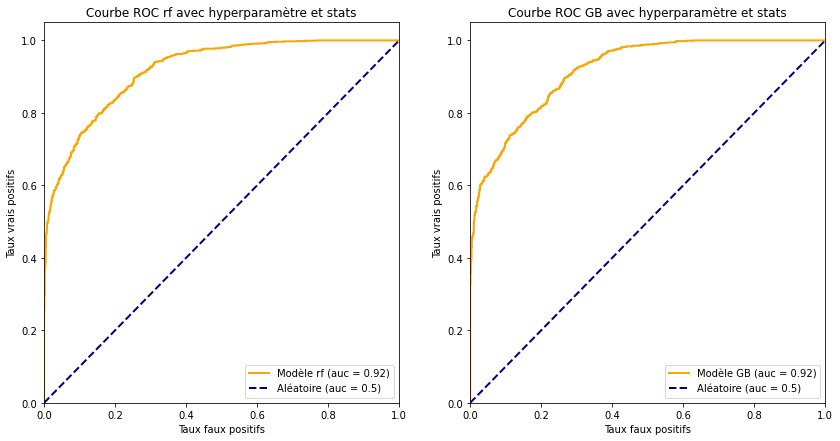

In [ ]:
#courbe ROC pour chaque modélisation sans hyperparamètre

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(fpr_rf1617ST, tpr_rf1617ST, color='orange', lw=2, label='Modèle rf (auc = %0.2f)' % roc_auc_rf1617ST)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC rf avec hyperparamètre et stats')
plt.legend(loc="lower right")


plt.subplot(122)
plt.plot(fpr_GB1617ST, tpr_GB1617ST, color='orange', lw=2, label='Modèle GB (auc = %0.2f)' % roc_auc_GB1617ST)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC GB avec hyperparamètre et stats')
plt.legend(loc="lower right");

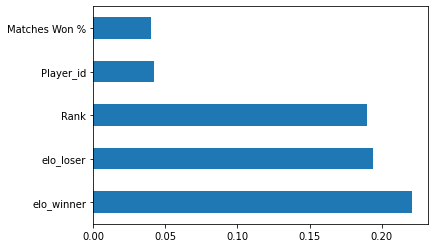

In [ ]:
#Interprétabilité du modèle
feat_importances = pd.Series(
    RF1617ST.feature_importances_, index=X_train_1617ST.columns)
feat_importances.nlargest(5).plot(kind='barh');

3. Modelisation avec moyenne mobile

In [ ]:
#application de la fonction moyenne mobile
#Fonction de moyenne roulante
def moyenne_roulante2(df, n=2):
    if 'match_id' in df.columns : 
        team_id ='match_id'
        date ='Date'
        
    df = df.sort_values(by=[team_id, date]).reset_index(drop=True)
    
    df_roulante2 = pd.DataFrame()
    
    for i in range(1, len(df)): 
            for colname in df.columns[[0,1,2,3,4,5,6]]:
                df_roulante2.loc[i, colname] = df.loc[i, colname]

            df_roulante2.loc[i, df.columns[7]] = df.loc[max(0, i-n):(i-1), df.columns[7]].mean()
            for colname in df.columns[7:]:
                df_roulante2.loc[i, colname] = df.loc[max(0, i-n):(i-1), colname].mean()
                
    return df_roulante2

In [ ]:
#creation du dataframe df_atp_1617ST_MB 
df_atp_1617ST_MB=df_atp_encodage[(df_atp_encodage['Annee']==2016) |(df_atp_encodage['Annee']==2017)]

#Trie par ordre croissant sur la Date
df_atp_1617ST_MB = df_atp_1617ST_MB.sort_values(by ='Date' , ascending = True)
display(df_atp_1617ST_MB.info())
#Suppression des variables
colonne_a_supp1617ST_MB = ['Round','Surface','Comment','Court','Series','Player','Wsets','Lsets', 
                  'proba_elo','Best of', 'WRank','LRank', 'Winner','Loser', 'index']
df_atp_1617ST_MB = df_atp_1617ST_MB.drop(colonne_a_supp1617ST_MB, axis = 1)

display(df_atp_1617ST_MB)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10522 entries, 77698 to 88199
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ATP           10522 non-null  int64  
 1   Location      10522 non-null  object 
 2   Tournament    10522 non-null  object 
 3   Date          10522 non-null  object 
 4   Series        10522 non-null  object 
 5   Court         10522 non-null  object 
 6   Surface       10522 non-null  object 
 7   Round         10522 non-null  object 
 8   Best of       10522 non-null  int64  
 9   Winner        10522 non-null  object 
 10  Loser         10522 non-null  object 
 11  WRank         10522 non-null  int64  
 12  LRank         10522 non-null  int64  
 13  Wsets         10450 non-null  float64
 14  Lsets         10448 non-null  float64
 15  Comment       10522 non-null  object 
 16  PSW           10482 non-null  float64
 17  PSL           10482 non-null  float64
 18  B365W         10502 no

None

,ATP,Location,Tournament,Date,PSW,PSL,B365W,B365L,elo_winner,elo_loser,...,Mois,surface,round,comment,court,series,match_id,Player_id,Rank,Player_cible
77698,2,Chennai,Chennai Open,2016-01-04,3.05,1.43,3.00,1.36,1461.295377,1672.444755,...,1,3,1,1,1,250,48849,1362,73,0
77684,3,Doha,Qatar Exxon Mobil Open,2016-01-04,1.01,51.00,1.00,51.00,1702.868388,1500.000000,...,1,3,1,1,1,250,48842,1483,31,1
77689,3,Doha,Qatar Exxon Mobil Open,2016-01-04,5.11,1.20,4.50,1.18,1496.532675,1748.987645,...,1,3,1,1,1,250,48844,1666,75,1
77687,3,Doha,Qatar Exxon Mobil Open,2016-01-04,1.48,2.84,1.44,2.62,1553.042743,1451.993935,...,1,3,1,1,1,250,48843,1836,90,0
77686,3,Doha,Qatar Exxon Mobil Open,2016-01-04,1.48,2.84,1.44,2.62,1553.042743,1451.993935,...,1,3,1,1,1,250,48843,1786,82,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88195,67,London,Masters Cup,2017-11-19,1.37,3.48,1.33,3.25,1956.268895,1903.306531,...,11,3,7,1,0,2000,54097,1685,8,0
88197,1,Brisbane,Brisbane International,2017-12-31,2.24,1.71,2.20,1.61,1723.326255,1793.794657,...,12,3,1,1,1,250,54098,1754,26,0
88198,1,Brisbane,Brisbane International,2017-12-31,3.14,1.41,2.75,1.40,1494.041611,1697.370640,...,12,3,1,1,1,250,54099,1734,44,0
88196,1,Brisbane,Brisbane International,2017-12-31,2.24,1.71,2.20,1.61,1723.326255,1793.794657,...,12,3,1,1,1,250,54098,1615,169,1


In [ ]:
df_atp_1617ST_MB=df_atp_1617ST_MB.merge(joueur_jointure, on='Player_id', how='left')
display(df_atp_1617ST_MB.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10871 entries, 0 to 10870
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ATP                     10871 non-null  int64  
 1   Location                10871 non-null  object 
 2   Tournament              10871 non-null  object 
 3   Date                    10871 non-null  object 
 4   PSW                     10831 non-null  float64
 5   PSL                     10831 non-null  float64
 6   B365W                   10851 non-null  float64
 7   B365L                   10851 non-null  float64
 8   elo_winner              10871 non-null  float64
 9   elo_loser               10871 non-null  float64
 10  Annee                   10871 non-null  int64  
 11  Mois                    10871 non-null  int64  
 12  surface                 10871 non-null  int64  
 13  round                   10871 non-null  int64  
 14  comment                 10871 non-null

None

In [ ]:
df_atp_1617ST_MB=df_atp_1617ST_MB.drop(['1stName','Name', 'Player_x', 'Player_y', 'Match Time', 'Location','Tournament'], axis=1)
df_atp_1617ST_MB=df_atp_1617ST_MB.fillna(0)
display(df_atp_1617ST_MB.isna().sum())

ATP                       0
Date                      0
PSW                       0
PSL                       0
B365W                     0
B365L                     0
elo_winner                0
elo_loser                 0
Annee                     0
Mois                      0
surface                   0
round                     0
comment                   0
court                     0
series                    0
match_id                  0
Player_id                 0
Rank                      0
Player_cible              0
Points Dominance          0
Games Dominance           0
Break Points Ratio        0
Ace %                     0
Double Fault %            0
1st Serve %               0
1st Serve Won %           0
2nd Serve Won %           0
Break Points Saved %      0
Service Points Won %      0
Service Games Won %       0
Ace Against %             0
Double Fault Against %    0
1st Srv. Return Won %     0
2nd Srv. Return Won %     0
Break Points Won %        0
Return Points Won % 

In [ ]:
#Ordre des variables:
col_0 = df_atp_1617ST_MB.pop('Date')
df_atp_1617ST_MB.insert(0, 'Date', col_0)
col_1 = df_atp_1617ST_MB.pop('Annee')
df_atp_1617ST_MB.insert(1, 'Annee', col_1)
col_2 = df_atp_1617ST_MB.pop('Mois')
df_atp_1617ST_MB.insert(2, 'Mois', col_2)
col_3 = df_atp_1617ST_MB.pop('match_id')
df_atp_1617ST_MB.insert(3, 'match_id', col_3)
col_4 = df_atp_1617ST_MB.pop('Player_id')
df_atp_1617ST_MB.insert(4, 'Player_id', col_4)
col_5 = df_atp_1617ST_MB.pop('Player_cible')
df_atp_1617ST_MB.insert(5, 'Player_cible', col_5)

df_atp_1617ST_MB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10871 entries, 0 to 10870
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10871 non-null  object 
 1   Annee                   10871 non-null  int64  
 2   Mois                    10871 non-null  int64  
 3   match_id                10871 non-null  int64  
 4   Player_id               10871 non-null  int64  
 5   Player_cible            10871 non-null  int64  
 6   ATP                     10871 non-null  int64  
 7   PSW                     10871 non-null  float64
 8   PSL                     10871 non-null  float64
 9   B365W                   10871 non-null  float64
 10  B365L                   10871 non-null  float64
 11  elo_winner              10871 non-null  float64
 12  elo_loser               10871 non-null  float64
 13  surface                 10871 non-null  int64  
 14  round                   10871 non-null

In [ ]:
#Application de la moyenne mobile sur df = le dataFrame avec l'ensemble des variables après encodage 
df_atp_moyenne_mobile_stats2016 = moyenne_roulante2(df_atp_1617ST_MB)

In [ ]:
df_atp_moyenne_mobile_stats2016

,Date,Annee,Mois,match_id,Player_id,Player_cible,ATP,PSW,PSL,B365W,...,Double Fault Against %,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %
1,2016-01-04,2016.0,1.0,48839.0,1520.0,1.0,3.0,1.500,2.760,1.500,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2016-01-04,2016.0,1.0,48840.0,1416.0,1.0,3.0,1.500,2.760,1.500,...,1.65,13.95,23.10,17.50,17.70,8.95,24.55,23.75,20.35,19.45
3,2016-01-04,2016.0,1.0,48840.0,1656.0,0.0,3.0,1.255,13.435,1.255,...,3.60,31.30,52.05,39.20,39.65,25.90,52.15,54.05,61.00,63.35
4,2016-01-04,2016.0,1.0,48841.0,1777.0,1.0,2.0,1.010,24.110,1.010,...,4.15,32.20,51.95,43.70,39.85,27.85,52.70,55.70,66.75,69.90
5,2016-01-04,2016.0,1.0,48841.0,1524.0,0.0,2.0,1.230,13.535,1.225,...,3.95,28.25,48.15,39.40,35.95,20.75,49.90,49.85,49.60,49.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10866,2017-11-19,2017.0,11.0,54097.0,1685.0,0.0,67.0,1.405,3.275,1.365,...,3.60,31.00,48.10,36.80,37.60,21.50,51.10,51.50,57.60,60.00
10867,2017-12-31,2017.0,12.0,54098.0,1754.0,0.0,1.0,1.370,3.480,1.330,...,3.70,31.40,51.60,39.90,39.40,25.95,51.50,52.85,59.30,63.10
10868,2017-12-31,2017.0,12.0,54098.0,1615.0,1.0,1.0,1.805,2.595,1.765,...,3.80,32.00,54.15,44.80,40.95,29.85,51.00,52.30,55.80,58.10
10869,2017-12-31,2017.0,12.0,54099.0,1734.0,0.0,1.0,2.240,1.710,2.200,...,3.65,30.00,51.40,42.15,38.65,24.90,50.00,49.85,50.90,50.00


In [ ]:
#Ajouter les get_dummies
df_atp_moyenne_mobile_stats2016 = df_atp_moyenne_mobile_stats2016.join(pd.get_dummies(df_atp_encodage['Tournament'], prefix= 'tournois'))
df_atp_moyenne_mobile_stats2016 = df_atp_moyenne_mobile_stats2016.join(pd.get_dummies(df_atp_encodage['Location'], prefix= 'loc'))
df_atp_moyenne_mobile_stats2016 = df_atp_moyenne_mobile_stats2016.fillna(0)
df_atp_moyenne_mobile_stats2016.isna().sum()

df_atp_moyenne_mobile_stats2016.info()

#temps d'exécution: 4 min

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10870 entries, 1 to 10870
Columns: 363 entries, Date to loc_Zagreb
dtypes: float64(40), object(1), uint8(322)
memory usage: 7.1+ MB


In [ ]:
data_1617ST_MB=df_atp_moyenne_mobile_stats2016.drop(['Player_cible','Date'], axis = 1)
target_1617ST_MB= df_atp_moyenne_mobile_stats2016['Player_cible']

In [ ]:
#préparation d'un train_test_split avec année 2016 et 2017
X_train_1617ST_MB,X_test_1617ST_MB, y_train_1617ST_MB,y_test_1617ST_MB= train_test_split(data_1617ST_MB, target_1617ST_MB, test_size=0.2, random_state=66, shuffle=False)

In [ ]:
#instanciation d'un RandomForest et d'un GradientBoosting avec hyperparamètres
RF1617ST_MB=RandomForestClassifier(criterion='entropy', max_features=None, min_samples_leaf=3, n_estimators=250)
GB1617ST_MB= GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss= 'deviance', max_features= None, min_samples_leaf= 3, n_estimators= 500, subsample= 0.5)

RF1617ST_MB.fit(X_train_1617ST_MB, y_train_1617ST_MB)
GB1617ST_MB.fit(X_train_1617ST_MB, y_train_1617ST_MB)

#affichage des matrices de confusion
y_pred1617_RF1617ST_MB= RF1617ST_MB.predict(X_test_1617ST_MB)
cm1617_RF1617ST_MB=pd.crosstab(y_test_1617ST_MB, y_pred1617_RF1617ST_MB,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model RandomForest:',RF1617ST_MB.score(X_test_1617ST_MB, y_test_1617ST_MB))
display('Matrice de confusion modele RandomForest:', cm1617_RF1617ST_MB)


y_pred1617_GB1617ST_MB= GB1617ST_MB.predict(X_test_1617ST_MB)
cm1617_GB1617ST_MB=pd.crosstab(y_test_1617ST_MB, y_pred1617_GB1617ST_MB,rownames=['classe reelle'], colnames=['classe predite'], normalize=True)
display('le score du model GradientBoosting:',GB1617ST_MB.score(X_test_1617ST_MB, y_test_1617ST_MB))
display('Matrice de confusion modele GradientBoosting:', cm1617_GB1617ST_MB)

'le score du model RandomForest:'

0.5809567617295308

'Matrice de confusion modele RandomForest:'

classe predite,0.0,1.0
classe reelle,,
0.0,0.260810,0.235971
1.0,0.183073,0.320147


'le score du model GradientBoosting:'

0.5699172033118676

'Matrice de confusion modele GradientBoosting:'

classe predite,0.0,1.0
classe reelle,,
0.0,0.336247,0.160534
1.0,0.269549,0.233671


In [ ]:
print('le rapport de classification pour RandomForest paramètres optimisés est:', '\n',classification_report(y_test_1617ST_MB, y_pred1617_RF1617ST_MB))
print('le rapport de classification pour GradientBoosting paramètres optimisés est:', '\n',classification_report(y_test_1617ST_MB, y_pred1617_GB1617ST_MB))


le rapport de classification pour RandomForest paramètres optimisés est: 
               precision    recall  f1-score   support

         0.0       0.59      0.53      0.55      1080
         1.0       0.58      0.64      0.60      1094

    accuracy                           0.58      2174
   macro avg       0.58      0.58      0.58      2174
weighted avg       0.58      0.58      0.58      2174

le rapport de classification pour GradientBoosting paramètres optimisés est: 
               precision    recall  f1-score   support

         0.0       0.56      0.68      0.61      1080
         1.0       0.59      0.46      0.52      1094

    accuracy                           0.57      2174
   macro avg       0.57      0.57      0.57      2174
weighted avg       0.57      0.57      0.57      2174



In [ ]:
#Calcul des probas pour chaque modèle afin de réaliser les courbes ROC
probs_rf1617ST_MB = RF1617ST_MB.predict_proba(X_test_1617ST_MB)
fpr_rf1617ST_MB, tpr_rf1617ST_MB, seuils_rf1617ST_MB = roc_curve(y_test_1617ST_MB, probs_rf1617ST_MB[:,1], pos_label =1)
roc_auc_rf1617ST_MB = auc(fpr_rf1617ST_MB, tpr_rf1617ST_MB)


probs_GB1617ST_MB = GB1617ST_MB.predict_proba(X_test_1617ST_MB)
fpr_GB1617ST_MB, tpr_GB1617ST_MB, seuils_GB1617ST_MB = roc_curve(y_test_1617ST_MB, probs_GB1617ST_MB[:,1], pos_label =1)
roc_auc_GB1617ST_MB = auc(fpr_GB1617ST_MB, tpr_GB1617ST_MB)




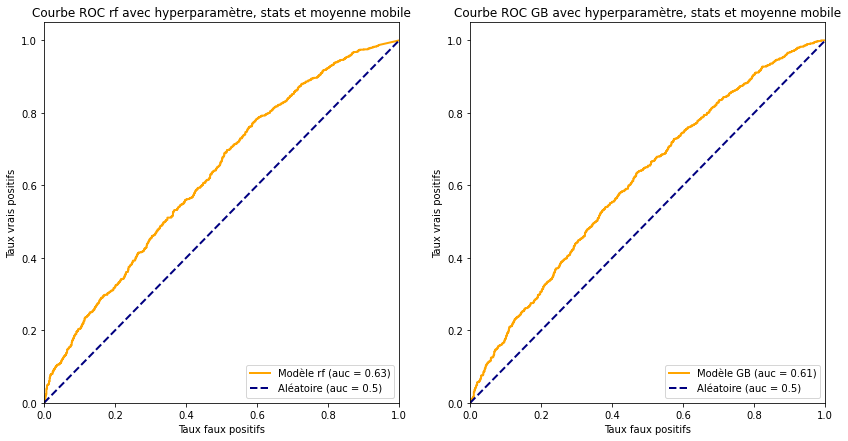

In [ ]:
#courbe ROC pour chaque modélisation sans hyperparamètre

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(fpr_rf1617ST_MB, tpr_rf1617ST_MB, color='orange', lw=2, label='Modèle rf (auc = %0.2f)' % roc_auc_rf1617ST_MB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC rf avec hyperparamètre, stats et moyenne mobile')
plt.legend(loc="lower right")


plt.subplot(122)
plt.plot(fpr_GB1617ST_MB, tpr_GB1617ST_MB, color='orange', lw=2, label='Modèle GB (auc = %0.2f)' % roc_auc_GB1617ST_MB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC GB avec hyperparamètre, stats et moyenne mobile')
plt.legend(loc="lower right");

In [ ]:
#travail pour soutenance: jointure entre joueur_jointure et df_atp avec player_id comme clé

df_atp_ST=df_atp_encodage.merge(joueur_jointure, on='Player_id', how='left')


In [ ]:
#----------------------------------------
# sauvegarde nouveau dataframe df_atp_ST
#----------------------------------------
filename='df_atp_ST.csv'
df_atp_final.to_csv(filename, index=False)
download = files.download(filename)
print (filename, 'sauvegarde')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

df_atp_ST.csv sauvegarde


In [ ]:
df_atp_ST

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,1st Srv. Return Won %,2nd Srv. Return Won %,Break Points Won %,Return Points Won %,Return Games Won %,Total Points Won %,Games Won %,Sets Won %,Matches Won %,1stName
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Lisnard J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Chennai,Gold Flake Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Vinciguerra A.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Chennai,Gold Flake Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Vinciguerra A.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Henman T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91185,17,Dubai,Dubai Tennis Championships,2018-03-03,ATP500,Outdoor,Hard,The Final,3,Bautista Agut R.,...,27.8,48.5,40.0,36.1,20.1,50.0,50.2,54.1,60.7,Lucas
91186,16,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Del Potro J.M.,...,23.3,47.1,32.3,32.4,13.5,49.8,49.5,48.4,44.7,Kevin
91187,18,Sao Paulo,Brasil Open,2018-03-04,ATP250,Indoor,Clay,The Final,3,Fognini F.,...,30.8,52.6,45.8,39.8,29.6,50.1,51.3,53.1,53.1,Fabio
91188,16,Acapulco,Abierto Mexicano,2018-03-04,ATP500,Outdoor,Hard,The Final,3,Del Potro J.M.,...,28.3,51.0,37.5,37.0,23.6,52.3,54.6,66.4,72.7,Juan Martin
